In [1]:
import os
import time

import numpy as np
import pandas 
import geopandas

from shapely.ops import unary_union
from shapely.geometry import Point, Polygon
from matplotlib import pyplot as plt
import matplotlib.patches as mpatches
from matplotlib.patches import FancyBboxPatch
import re
from pprint import pprint
from matplotlib.path import Path
from matplotlib.patches import BoxStyle



thisyear = 2018
#this_state = 'MO'

script_dir = '/home/idies/workspace/Storage/raddick/jordanraddick.com/gerrymandering/'
data_dir = '/home/idies/workspace/Storage/raddick/jordanraddick.com/gerrymandering/districts_with_data/'
output_dir = data_dir

acs5_dir = '/home/idies/workspace/Temporary/raddick/census_scratch/acs5/{0:.0f}/estimates/'.format(thisyear)
shapefiledir = '/home/idies/workspace/Temporary/raddick/census_scratch/shapefiles/{0:.0f}/'.format(thisyear)
extras_dir = '/home/idies/workspace/Storage/raddick/census/extras/'
#separated_roads_dir = output_dir = '/home/idies/workspace/Temporary/raddick/jordanraddick.com_temp/roads/{0:}/'.format(this_state.lower())


water_area_tol = 1 * 1000 * 1000
overlap_area_tract_tol = 22000
overlap_area_bg_tol = 4000
#smallest tract in US is Cook County, Illinois Tract 307.02 (area = 22,094 m^2)
#smallest block group in US is Miami-Dade County, FL, Census Tract 2703, block group 7 (area = 4,436 m^2)
equal_area_crs = {'init': 'epsg:2163'}  # An equal area projection: https://epsg.io/2163

scale = 1
#map_buffer = 0.25 # extra room on each edge of the maps, in degres

#plt.rc('axes', prop_cycle=default_cycler)

district_color_cycle = ['red', 'green', 'orange', 'cyan', 'yellow', 'pink', 'gray', 'lime', 'navajowhite', 'cornflowerblue', 'darkseagreen', 'thistle', 'tomato', 'silver', 'blueviolet', 'olive', 'peru', 'dodgerblue']
district_contrast_color_cycle = ['green', 'red', 'navy', 'black', 'purple', 'lime', 'black', 'red', 'red', 'black', 'red', 'black', 'black', 'white', 'yellow', 'yellow', 'yellow', 'yellow']

debug = 1
g = 0




def makebox(manual_xlim, manual_ylim):

    points = []
    points.append(Point(manual_xlim[0],manual_ylim[1]))
    points.append(Point(manual_xlim[1],manual_ylim[1]))
    points.append(Point(manual_xlim[1],manual_ylim[0]))
    points.append(Point(manual_xlim[0],manual_ylim[0]))
    
    coords = [(p.x, p.y) for p in points]    
    metrobox = Polygon(coords)
    
    return metrobox 
# we may derive from matplotlib.patches.BoxStyle._Base class.
# You need to override transmute method in this case.
class shield(BoxStyle._Base):
    """
    A simple box.
    """

    def __init__(self, pad=0.3):
        """
        The arguments need to be floating numbers and need to have
        default values.

         *pad*
            amount of padding
        """

        self.pad = pad
        super().__init__()

    def transmute(self, x0, y0, width, height, mutation_size):
        """
        Given the location and size of the box, return the path of
        the box around it.

         - *x0*, *y0*, *width*, *height* : location and size of the box
         - *mutation_size* : a reference scale for the mutation.

        Often, the *mutation_size* is the font size of the text.
        You don't need to worry about the rotation as it is
        automatically taken care of.
        """

        # padding
        pad = mutation_size * self.pad

        # width and height with padding added.
        width, height = width + 2.*pad, \
                        height + 2.*pad,

        # boundary of the padded box
        x0, y0 = x0-pad, y0-pad,
        x1, y1 = x0+width, y0 + height

        cp = [(0.5*(x0+x1), (y0-2.*pad)), # bottom
              (x1, y0),  # right lower-mid
              (x1+pad, (y0+y1)/2.),  # far right mid
              (x1, y1+pad),  # top right corner
              ((x0+x1)/2,y1),  # dip from top
              (x0, y1+pad),  # top left corner
              (x0-pad, (y0+y1)/2.),    # far left mid
              (x0, y0),  # left lower-mid
              ((x0+x1)/2., (y0-2.*pad)),  # return to bottom
              ((x0+x1)/2., (y0-2.*pad))]
        
        
        com = [Path.MOVETO,  # start
               Path.CURVE4, # curve to right mid
               Path.LINETO,  # line to far right mid
               Path.LINETO, # line to top right corner
               Path.CURVE3,  # line to dip
               Path.LINETO,  # line to top left corner
               Path.CURVE4,   # curve to far left mid
               Path.LINETO,   # line to left lower-mid
               Path.LINETO,
               Path.CLOSEPOLY]

        path = Path(cp, com)

        return path

BoxStyle._style_list["shield"] = shield



def parse_road_name(thename):
    try:
        annotator = thisrow['FULLNAME'][re.search('\d',thisrow['FULLNAME']).start():]
    except AttributeError:
        try: 
            annotator = thisrow['FULLNAME'][re.search('Hwy',thisrow['FULLNAME']).end():]
        except AttributeError:
            annotator = thisrow['FULLNAME']
    return annotator


road_label_format = { 
    'I': { 'labelsize': 16, 'thecolor': 'yellow', 'thebbox': dict(boxstyle="shield", fc='blue', ec='orange') },     
    'U': { 'labelsize': 14, 'thecolor': 'black', 'thebbox': dict(boxstyle="shield", fc='white', ec='black') },
    'S': { 'labelsize': 12, 'thecolor': 'black', 'thebbox': dict(boxstyle="square,pad=0.25", fc='white', ec='black')},
    'C': { 'labelsize': 10, 'thecolor': 'black', 'thebbox': dict(boxstyle="sawtooth,pad=0.5", fc='white') }, 
    'M': { 'labelsize': 16, 'thecolor': 'black'},
    'O': { 'labelsize': 11, 'thecolor': 'yellow' }
}
old_map_buffer_ratio = -1
print('ok')



ok


# Get congressional district shapefiles

WITH data on metro and city areas as a percentage of total district area.

This assumes that you have already run <code>districts-cities.ipynb</code>.

In [2]:
s = time.time()
print('reading congressional districts with urban/rural area data...')
cd_gdf = geopandas.read_file(data_dir+'cd116_with_areas_and_types_435.shp')

print('Fixing at-large districts by setting district number to 1...')
cd_gdf.loc[cd_gdf['CD116FP'] == 0, 'CD116FP'] = 1  # At-large districts will be called District 1

cd_gdf = cd_gdf.rename(columns = {'pct_metro_': 'pct_metro_area', 'pct_city_a': 'pct_city_area'})
cd_gdf.loc[:, 'CD116FP'] = cd_gdf['CD116FP'].apply(lambda x: int(x))
cd_gdf = cd_gdf.set_index('GEOID')

e = time.time()
g = g + (e-s)
print('Read {0:,.0f} districts in {1:,.1f} seconds.'.format(len(cd_gdf), e-s))
#sorted(cd_gdf[cd_gdf['CD116FP'] == 0]['STUSAB'].tolist())


reading congressional districts with urban/rural area data...
Fixing at-large districts by setting district number to 1...
Read 435 districts in 2.6 seconds.


# Load block groups (nationwide)

In [3]:
s = time.time()
bg_file_list = [shapefiledir+'BG/'+x for x in os.listdir(shapefiledir+'BG/') if ((x[-4:] == '.shp'))]
bg_gdf = geopandas.GeoDataFrame()

for i in range(0, len(bg_file_list)):
    if (debug >= 1):
        if ((np.mod(i,10) == 0) | (i == len(bg_file_list)-1)):
            print('\tReading file {0:,.0f} of {1:,.0f}...'.format(i+1, len(bg_file_list)))
    bg_gdf_i = geopandas.read_file(bg_file_list[i])
    bg_gdf = pandas.concat((bg_gdf, bg_gdf_i), axis=0, sort=False)

print('converting block group identifiers and coords to numeric...')
bg_gdf.loc[:, 'STATEFP'] = pandas.to_numeric(bg_gdf['STATEFP'], errors='coerce')
bg_gdf.loc[:, 'COUNTYFP'] = pandas.to_numeric(bg_gdf['COUNTYFP'], errors='coerce')
bg_gdf.loc[:, 'TRACTCE'] = pandas.to_numeric(bg_gdf['TRACTCE'].apply(lambda x: x[0:4]+'.'+x[4:]), errors='coerce')
bg_gdf.loc[:, 'BLKGRPCE'] = pandas.to_numeric(bg_gdf['BLKGRPCE'], errors='coerce')
bg_gdf.loc[:, 'INTPTLAT'] = pandas.to_numeric(bg_gdf['INTPTLAT'], errors='coerce')
bg_gdf.loc[:, 'INTPTLON'] = pandas.to_numeric(bg_gdf['INTPTLON'], errors='coerce')

#bg_gdf.loc[:, 'NAME'] = pandas.to_numeric(tract_gdf['NAME'], errors='coerce')
# bg_gdf = tract_gdf.sort_values(by='NAME')

print('assigning GEOID as index...')
bg_gdf.loc[:, 'GEOID'] = bg_gdf['GEOID'].apply(lambda x: '15000US'+str(x))
bg_gdf = bg_gdf.set_index('GEOID')

e = time.time()
g = g + (e-s)
if (debug >= 1):
    print('Read {0:,.0f} census block groups in {1:,.1f} seconds!'.format(len(bg_gdf), e-s))

#bg_gdf.sample(1).T


	Reading file 1 of 51...
	Reading file 11 of 51...
	Reading file 21 of 51...
	Reading file 31 of 51...
	Reading file 41 of 51...
	Reading file 51 of 51...
converting block group identifiers and coords to numeric...
assigning GEOID as index...
Read 217,739 census block groups in 161.0 seconds!


## Look up state and county names from numbers

In [4]:
s = time.time()

print('looking up state names from numbers...')
state_codes_df = pandas.read_csv(extras_dir+'statecodes.csv')
state_codes_df = state_codes_df.rename(columns={'STATE': 'STATEFP'})
bg_gdf = bg_gdf.reset_index().merge(state_codes_df, how='left', on='STATEFP').set_index('GEOID')


print('looking up county names from numbers...')
county_names_df = pandas.read_excel(extras_dir+'all-geocodes-v2019.xlsx', header=4)
county_names_df = county_names_df[county_names_df['Summary Level'] == 50]
county_names_df = county_names_df.rename(columns={'State Code (FIPS)': 'STATEFP', 'County Code (FIPS)': 'COUNTYFP', 'Area Name (including legal/statistical area description)': 'COUNTY_NAME' })
bg_gdf = bg_gdf.reset_index().merge(county_names_df[['STATEFP', 'COUNTYFP', 'COUNTY_NAME']], how='left', on=['STATEFP', 'COUNTYFP']).set_index('GEOID')

e = time.time()
g = g + (e-s)
print('Added state and county names in {0:,.1f} seconds!'.format(e-s))


looking up state names from numbers...
looking up county names from numbers...
Added state and county names in 15.5 seconds!


## Get population data, and join onto shapefiles

In [5]:
s = time.time()
print('reading ACS5 census data for {0:.0f}...'.format(thisyear))
acs5_estimates_df = pandas.read_csv(acs5_dir+'estimates_acs{0:}_tract_bg_gerrymandering.csv'.format(thisyear), index_col='GEOID')

print('joining population data onto block group shapefiles...')
bg_gdf = bg_gdf.join(acs5_estimates_df[['B01001_001', 'Geography Name']], how='left')
bg_gdf = bg_gdf.rename(columns={'B01001_001': 'total_population'})

e = time.time()
g = g + (e-s)
print('\nadded ACS5 census data to {0:,.0f} block groups in {1:,.0f} seconds!'.format(len(bg_gdf), e-s))


reading ACS5 census data for 2018...
joining population data onto block group shapefiles...

added ACS5 census data to 217,739 block groups in 5 seconds!


# Geo-match congressional districts

If a tract overlaps with only one district, match that tract to its district.
If it overlaps multiple districts, divide into block groups and match each block group to its matching districts.

# READ FROM FILE

## Get what has been matched so far

In [ ]:
# s = time.time()
# print('reading districts that have been matched so far...')
# assembler_df = pandas.read_csv(output_dir+'raw_district_files/ak_to_ca.csv', encoding='utf-8', index_col='GEOID')
# assembler_gdf = geopandas.GeoDataFrame(assembler_df.join(bg_gdf.geometry))
# assembler_gdf.crs = bg_gdf.crs


# # cd_gdf = cd_gdf[~cd_gdf['STUSAB'].isin(assembler_gdf['STUSAB'].drop_duplicates().tolist())]
# # bg_gdf = bg_gdf[~bg_gdf['STUSAB'].isin(assembler_gdf['STUSAB'].drop_duplicates().tolist())]

# #print('backing up...')
# # cd_gdf_bk = cd_gdf
# # bg_gdf_bk = bg_gdf
# #assembler_gdf_bk = assembler_gdf

# e = time.time()
# g = g + (e-s)
# print('Kept {0:,.0f} block groups in {1:,.1f} seconds!'.format(len(bg_gdf),e-s))

# assembler_gdf.groupby('STUSAB')['block_based_district'].max().sort_values(ascending=False)



### READ AFRESH

In [6]:
s = time.time()
print('reading districts that have been matched so far...')
assembler_df = pandas.read_csv(data_dir+'block_group_with_district_1_36.csv', encoding='utf-8', index_col='GEOID')
assembler_gdf = geopandas.GeoDataFrame(assembler_df.join(bg_gdf.geometry))
assembler_gdf.crs = bg_gdf.crs


# cd_gdf = cd_gdf[~cd_gdf['STUSAB'].isin(assembler_gdf['STUSAB'].drop_duplicates().tolist())]
# bg_gdf = bg_gdf[~bg_gdf['STUSAB'].isin(assembler_gdf['STUSAB'].drop_duplicates().tolist())]

print('backing up...')
cd_gdf_bk = cd_gdf
bg_gdf_bk = bg_gdf
assembler_gdf_bk = assembler_gdf

e = time.time()
g = g + (e-s)
print('Kept {0:,.0f} block groups in {1:,.1f} seconds!'.format(len(bg_gdf),e-s))




reading districts that have been matched so far...
backing up...
Kept 217,739 block groups in 2.9 seconds!


## California

These are harder, because first we have to know which block groups overlap multiple districts.

Create a function to mark those.

### Create function to mark block groups with the districts they overlap

In [7]:
def mark_block_groups_with_districts_bitmask_values(block_group_info_gdf, congressional_district_info_gdf, debug=0):    
    #working_with_state = block_group_info_gdf['STATE_NAME'].head(1).values[0]
    
    marked_s = pandas.Series()
    
    equal_area_crs = {'init': 'epsg:2163'}  # An equal area projection: https://epsg.io/2163
    cnt = 0
    #if (debug > 0):    
    #    print('\tAssigning bitmask values to block groups in {0:}...'.format(working_with_state))
    
    for ix, thisrow in block_group_info_gdf.iterrows():    
        bitmasker = 0
        if (debug > 1):
            print(ix)
            print('\t\tMatching {0:}, {1:} census tract {2:}, block group {3:}...'.format(thisrow['STATE_NAME'], thisrow['COUNTY_NAME'], thisrow['TRACTCE'], thisrow['BLKGRPCE']))
            print('\n')
        if ((np.mod(cnt,1000) == 0) | (cnt == len(block_group_info_gdf) - 1)):
            if (debug > 1):
                print('\t\t\tprocessing row {0:,.0f} of {1:,.0f}...'.format(cnt+1, len(block_group_info_gdf)))
            else:
                print('\t\tprocessing row {0:,.0f} of {1:,.0f}...'.format(cnt+1, len(block_group_info_gdf)))
                
        for jx, thatrow in congressional_district_info_gdf.iterrows():
            if (thisrow.geometry.intersects(thatrow.geometry)):
                this_district_overlap_area = block_group_info_gdf[block_group_info_gdf.index == ix].to_crs(equal_area_crs).geometry.values[0].intersection(congressional_district_info_gdf[congressional_district_info_gdf.index == jx].to_crs(equal_area_crs).geometry.values[0]).area
                if (this_district_overlap_area >= overlap_area_bg_tol):
                    bitmasker = bitmasker + 2**(thatrow['CD116FP']-1)
                    if (debug > 1):
                        print('\t\t\t\tIntersects District {0:.0f} with overlap area {1:,.1f} km^2...'.format(thatrow['CD116FP'], this_district_overlap_area/1000000))               
        marked_s.loc[ix] = bitmasker
        cnt = cnt + 1
        
    return marked_s
print('defined district-marking function!')
#assembler_gdf.groupby('STUSAB')['block_based_district'].max().sort_values(ascending=False)


defined district-marking function!


## Find block group / district overlaps, assign districts to non-overlapping block groups

Uses function defined above

In [8]:
s = time.time()

print('getting from backup...')
bg_gdf = bg_gdf_bk
assembler_gdf = assembler_gdf_bk


for this_state in ['CA']:
    state_full_name = bg_gdf[bg_gdf['STUSAB'] == this_state]['STATE_NAME'].values[0]
    print('\n')
    print('Processing {0:}...'.format(state_full_name))
    assembler_i_gdf = bg_gdf[bg_gdf['STUSAB'] == this_state]

    district_bitmask_values_s = mark_block_groups_with_districts_bitmask_values(
        bg_gdf[bg_gdf['STUSAB'] == this_state][['STATE_NAME', 'COUNTY_NAME', 'TRACTCE', 'BLKGRPCE', 'total_population', 'geometry']], 
        cd_gdf[cd_gdf['STUSAB'] == this_state][['STUSAB', 'CD116FP', 'geometry']], 
        debug
    )
    assembler_i_gdf = assembler_i_gdf.assign(congressional_districts_bitmask_values = district_bitmask_values_s)


    if (debug > 0):
        print('\tconverting bitmask values to human-readable bitmasks...')        
    nDistrictsForBitmaskeration = cd_gdf[cd_gdf['STUSAB'] == this_state]['CD116FP'].max()
    assembler_i_gdf = assembler_i_gdf.assign(congressional_districts_bitmask = 
                                             assembler_i_gdf['congressional_districts_bitmask_values'].apply(lambda x: 'x'+np.binary_repr(int(x)).zfill(nDistrictsForBitmaskeration)[::-1])
                                            )

    if (debug > 0):
        print('\tcounting number of districts each block group overlaps...')        

    assembler_i_gdf = assembler_i_gdf.assign(nDistricts = 
                                             assembler_i_gdf['congressional_districts_bitmask'].apply(lambda x: x[1:].count("1"))
                                            )
    if (debug > 0):
        print('\tassigning congressional district to each block group with only one overlap...')

    assembler_i_gdf = assembler_i_gdf.assign(block_based_district = np.nan)
    assembler_i_gdf.loc[
        assembler_i_gdf['nDistricts'] == 1, 
        'block_based_district'] = assembler_i_gdf[
                        assembler_i_gdf['nDistricts'] == 1
                    ]['congressional_districts_bitmask'].apply(lambda x: x.find("1"))

    print('\t...-1 otherwise...')
    assembler_i_gdf.loc[assembler_i_gdf['nDistricts'] > 1, 'block_based_district'] = -1

    #assembler_i_gdf.to_file(output_dir+'raw_district_files/nj_raw.shp')

    if (debug > 0):
        print('\tjoining {0:} to the rest of the assembler dataframe...'.format(state_full_name))
    assembler_gdf = pandas.concat((assembler_gdf, assembler_i_gdf), axis=0, sort=True)
    if (debug > 0):
        print("\n")
e = time.time()
g = g + (e-s)

print('matched districts for {0:,.0f} block groups in {1:} in {2:,.0f} minutes {3:,.0f} seconds!'.format(len(assembler_i_gdf), this_state, np.floor((e-s)/60), np.floor((e-s)%60)))

print('backing up...')
assembler_gdf_justparsed = assembler_gdf

e = time.time()
g = g + (e-s)

#print('Read {0:,.0f} rows in {1:,.0f} seconds!'.format(e-s, ))
print('Got {0:,.0f} block groups in {1:,.0f} minutes {2:,.0f} seconds!'.format(len(assembler_gdf), np.floor((e-s)/60), np.floor((e-s)%60)))

# print(assembler_gdf.groupby('STUSAB').size())
# print(assembler_gdf.groupby(['STUSAB', 'nDistricts']).size())
#print(assembler_gdf.groupby(['STUSAB', 'block_based_district']).size())
# assembler_gdf.sample(2).T
#assembler_gdf[assembler_gdf['STUSAB'] == this_state].groupby('congressional_districts_bitmask').size()
assembler_gdf.groupby('STUSAB')['block_based_district'].max().sort_values(ascending=False)

# matched districts for 23,212 block groups in CA in 51 minutes 17 seconds!
# backing up...
# Got 201,478 block groups in 51 minutes 17 seconds!


getting from backup...


Processing California...
		processing row 1 of 23,212...
		processing row 1,001 of 23,212...
		processing row 2,001 of 23,212...
		processing row 3,001 of 23,212...
		processing row 4,001 of 23,212...
		processing row 5,001 of 23,212...
		processing row 6,001 of 23,212...
		processing row 7,001 of 23,212...
		processing row 8,001 of 23,212...
		processing row 9,001 of 23,212...
		processing row 10,001 of 23,212...
		processing row 11,001 of 23,212...
		processing row 12,001 of 23,212...
		processing row 13,001 of 23,212...
		processing row 14,001 of 23,212...
		processing row 15,001 of 23,212...
		processing row 16,001 of 23,212...
		processing row 17,001 of 23,212...
		processing row 18,001 of 23,212...
		processing row 19,001 of 23,212...
		processing row 20,001 of 23,212...
		processing row 21,001 of 23,212...
		processing row 22,001 of 23,212...
		processing row 23,001 of 23,212...
		processing row 23,212 of 23,212...
	converting bitmask values to human-rea

STUSAB
CA    53.0
TX    36.0
NY    27.0
FL    27.0
IL    18.0
PA    18.0
OH    16.0
GA    14.0
MI    14.0
NC    13.0
NJ    12.0
VA    11.0
WA    10.0
TN     9.0
AZ     9.0
MA     9.0
IN     9.0
MO     8.0
MN     8.0
MD     8.0
WI     8.0
SC     7.0
AL     7.0
CO     7.0
KY     6.0
LA     6.0
CT     5.0
OK     5.0
OR     5.0
KS     4.0
IA     4.0
MS     4.0
NV     4.0
AR     4.0
UT     4.0
WV     3.0
NM     3.0
NE     3.0
ME     2.0
NH     2.0
ID     2.0
RI     2.0
HI     2.0
WY     1.0
DE     1.0
MT     1.0
ND     1.0
SD     1.0
VT     1.0
AK     1.0
Name: block_based_district, dtype: float64

In [ ]:
# s = time.time()
# pandas.DataFrame(assembler_gdf[[x for x in assembler_gdf.columns if x != 'geometry']]
#                 ).to_csv(output_dir+'raw_district_files/ak_to_ca.csv', encoding='utf-8')
# e = time.time()
# g = g + (e-s)

# print('Wrote out {0:,.0f} block groups in {1:,.0f} minutes {2:,.0f} seconds!'.format(len(dallas_gdf), np.floor((e-s)/60), np.floor((e-s)%60)))


In [9]:
s = time.time()
print('Assigning districts based on examination to block groups that overlap multiple districts...')


print('assigning districts...')

### CALIFORNIA

##### Bay Area
assembler_gdf.loc[['15000US060971506122'], 'block_based_district'] = 5
assembler_gdf.loc[['15000US060952522024', '15000US060952522014'], 'block_based_district'] = 3
assembler_gdf.loc[['15000US060952521021', '15000US060952522021'], 'block_based_district'] = 5
assembler_gdf.loc[['15000US060133180002', '15000US060133560022', '15000US060133180003', '15000US060133601013', '15000US060133592022'], 'block_based_district'] = 5
assembler_gdf.loc[['15000US060139900000', '15000US060133560024', '15000US060133211033', '15000US060133200041', '15000US060133211014', '15000US060133630004', '15000US060133601012', '15000US060133601012', '15000US060133601022'], 'block_based_district'] = 11
assembler_gdf.loc[['15000US060770052061', '15000US060770052062', '15000US060770051192', '15000US060770051313', '15000US060770051351'], 'block_based_district'] = 9
assembler_gdf.loc[['15000US060770055011', '15000US060770052021', '15000US060770051221'], 'block_based_district'] = 10
assembler_gdf.loc[['15000US060133551083', '15000US060133040011', '15000US060133040021', '15000US060133060032', '15000US060133080011', '15000US060133551081'], 'block_based_district'] = 9
assembler_gdf.loc[['15000US060133551071', '15000US060133551121'], 'block_based_district'] = 11
assembler_gdf.loc[['15000US060133452031', '15000US060133452023', '15000US060133451051'], 'block_based_district'] = 11
assembler_gdf.loc[['15000US060133551171', '15000US060133551161', '15000US060133451131', '15000US060133451142', '15000US060133451141', '15000US060133551143'], 'block_based_district'] = 15
assembler_gdf.loc[['15000US060750179021'], 'block_based_district'] = 12
assembler_gdf.loc[['15000US060759901000', '15000US060750255001', '15000US060750605023', '15000US060750330003', '15000US060750330004', '15000US060750303022', '15000US060750304003' , '15000US060750308005'], 'block_based_district'] = 12
assembler_gdf.loc[['15000US060750263023', '15000US060750255002', '15000US060750306002', '15000US060750308004'], 'block_based_district'] = 14
assembler_gdf.loc[['15000US060014338001', '15000US060014338003'], 'block_based_district'] = 13
assembler_gdf.loc[['15000US060019900000', '15000US060014301021', '15000US060014338002', '15000US060014338004', '15000US060014304002', '15000US060014328003'], 'block_based_district'] = 15
assembler_gdf.loc[['15000US060819901000', '15000US060816138002', '15000US060816117002', '15000US060816117004', '15000US060816096033' , '15000US060816104001', '15000US060816100001', '15000US060816102032', '15000US060816102012', '15000US060816109003'], 'block_based_district'] = 14
assembler_gdf.loc[['15000US060816134003', '15000US060816134002', '15000US060816097001', '15000US060816099001', '15000US060816105001'], 'block_based_district'] = 18
assembler_gdf.loc[['15000US060014507013', '15000US060014415242', '15000US060014419243', '15000US060014415031'], 'block_based_district'] = 15
assembler_gdf.loc[['15000US060014431031', '15000US060014418001', '15000US060014418003', '15000US060014419241'], 'block_based_district'] = 17
assembler_gdf.loc[['15000US060855077023', '15000US060855079041', '15000US060855079042', '15000US060855080043', '15000US060855059003', '15000US060855077031', '15000US060855077032', '15000US060855077034', '15000US060855077035', '15000US060855078052', '15000US060855084015'], 'block_based_district'] = 17
assembler_gdf.loc[['15000US060855117071', '15000US060855047001', '15000US060855076001', '15000US060855100011', '15000US060855058002' , '15000US060855059002'], 'block_based_district'] = 18
assembler_gdf.loc[['15000US060855043081', '15000US060855052031', '15000US060855057003'], 'block_based_district'] = 17
assembler_gdf.loc[['15000US060855135001', '15000US060855042011', '15000US060855051002'], 'block_based_district'] = 19
assembler_gdf.loc[['15000US060855119112', '15000US060855119111', '15000US060855119113', '15000US060855120271', '15000US060855120521', '15000US060855029022', '15000US060855022022' ,'15000US060855022023', '15000US060855020011', '15000US060855058001', '15000US060855020023', '15000US060855026011'], 'block_based_district'] = 18
assembler_gdf.loc[['15000US060855121001', '15000US060855120242', '15000US060855120523', '15000US060855029032', '15000US060855029033', '15000US060855029021', '15000US060855026012', '15000US060855023022', '15000US060855005003', '15000US060855005004', '15000US060855020022'], 'block_based_district'] = 19
assembler_gdf.loc[['15000US060871212002', '15000US060871212001'], 'block_based_district'] = 18
assembler_gdf.loc[['15000US060879901000', '15000US060871212003', '15000US060871004001', '15000US060871005003', '15000US060871012003', '15000US060871207003'], 'block_based_district'] = 20
assembler_gdf.loc[['15000US060855126022', '15000US060855124011', '15000US060855125092', '15000US060855125101'], 'block_based_district'] = 19
assembler_gdf.loc[['15000US060855126021', '15000US060855125051', '15000US060855125062', '15000US060855126043', '15000US060855126032'], 'block_based_district'] = 20



####### Southern California
assembler_gdf.loc[['15000US060710092021'], 'block_based_district'] = 8
assembler_gdf.loc[['15000US060290060073'], 'block_based_district'] = 23
assembler_gdf.loc[['15000US060379012054', '15000US060379012053', '15000US060379007031'], 'block_based_district'] = 23
assembler_gdf.loc[['15000US060379003001', '15000US060379012131', '15000US060379006022', '15000US060379006062', '15000US060379102021', '15000US060379103011'], 'block_based_district'] = 25
assembler_gdf.loc[['15000US061110001001'], 'block_based_district'] = 24
assembler_gdf.loc[['15000US061119901000'], 'block_based_district'] = 26
assembler_gdf.loc[['15000US061110074053'], 'block_based_district'] = 26
assembler_gdf.loc[['15000US061110075111'], 'block_based_district'] = 30
assembler_gdf.loc[['15000US061110075061', '15000US061110075071', '15000US061110075142', '15000US061110079012', '15000US061110084022', '15000US061110075143'], 'block_based_district'] = 25
assembler_gdf.loc[['15000US061110084021', '15000US061110085003', '15000US061110075091', '15000US061110079012'], 'block_based_district'] = 26
assembler_gdf.loc[['15000US060379108111'], 'block_based_district'] = 27
assembler_gdf.loc[['15000US060379302002'], 'block_based_district'] = 28
assembler_gdf.loc[['15000US060379110013'], 'block_based_district'] = 25
assembler_gdf.loc[['15000US060379303012'], 'block_based_district'] = 27
assembler_gdf.loc[['15000US060379108051', '15000US060379108101'], 'block_based_district'] = 25
assembler_gdf.loc[['15000US061110075121', '15000US060371081021', '15000US060371081011'], 'block_based_district'] = 25
assembler_gdf.loc[['15000US060371132351', '15000US060371082021', '15000US060371066032', '15000US060371066431', '15000US060371082012', '15000US060371112061', '15000US060371112062'], 'block_based_district'] = 30
assembler_gdf.loc[['15000US060378003261', '15000US060378003263'], 'block_based_district'] = 26
assembler_gdf.loc[['15000US060378003242', '15000US060378003262'], 'block_based_district'] = 33
assembler_gdf.loc[['15000US060379301011', '15000US060374604011', '15000US060374617002', '15000US060374639002', '15000US060374639002'], 'block_based_district'] = 27
assembler_gdf.loc[['15000US060374608002', '15000US060374639002', '15000US060374639001', '15000US060374637002'], 'block_based_district'] = 28
assembler_gdf.loc[['15000US060710008081', '15000US060710008172'], 'block_based_district'] = 27
assembler_gdf.loc[['15000US060374005011', '15000US060374002051', '15000US060374002043', '15000US060374009002', '15000US060374039011'], 'block_based_district'] = 27
assembler_gdf.loc[['15000US060374016012', '15000US060374004031', '15000US060374006042', '15000US060374039013', '15000US060374008001'], 'block_based_district'] = 32
assembler_gdf.loc[['15000US060374315022', '15000US060374315023', '15000US060374315021', '15000US060374315022', '15000US060374321012', '15000US060374321025', '15000US060374321011', '15000US060374321022', '15000US060374329021'], 'block_based_district'] = 27
assembler_gdf.loc[['15000US060374310022','15000US060374313001', '15000US060374313002', '15000US060374303014', '15000US060374325001', '15000US060374325004', '15000US060374315011'], 'block_based_district'] = 32
assembler_gdf.loc[['15000US060374017011', '15000US060374017012'], 'block_based_district'] = 27
assembler_gdf.loc[['15000US060374017041'], 'block_based_district'] = 35
assembler_gdf.loc[['15000US060374824022', '15000US060374825221'], 'block_based_district'] = 27
assembler_gdf.loc[['15000US060375300031'], 'block_based_district'] = 38
assembler_gdf.loc[['15000US060375304002'], 'block_based_district'] = 27
assembler_gdf.loc[['15000US060379302001', '15000US060371041243', '15000US060379800261', '15000US060371021031', '15000US060371021042'], 'block_based_district'] = 28 
assembler_gdf.loc[['15000US060371041242', '15000US060371032001', '15000US060371222002', '15000US060371211021', '15000US060371211023', '15000US060371032002', '15000US060379800211'], 'block_based_district'] = 29 
assembler_gdf.loc[['15000US060371897013', '15000US060373108005', '15000US060373117006', '15000US060371437001'], 'block_based_district'] = 28
assembler_gdf.loc[['15000US060373110002', '15000US060373116004'], 'block_based_district'] = 30
assembler_gdf.loc[['15000US060371923001', '15000US060371944011', '15000US060371944023', '15000US060371924104', '15000US060371926201'], 'block_based_district'] = 28
assembler_gdf.loc[['15000US060371864041', '15000US060371924103', '15000US060371925201', '15000US060371925202', '15000US060371927002', '15000US060371958021', '15000US060371957103', '15000US060371926202'], 'block_based_district'] = 34
assembler_gdf.loc[['15000US060371093003', '15000US060371114001', '15000US060379800081', '15000US060371252003', '15000US060371284004', '15000US060371285002'], 'block_based_district'] = 29
assembler_gdf.loc[['15000US060371066031', '15000US060379800221', '15000US060371311002', '15000US060371311003', '15000US060371321022', '15000US060371236013', '15000US060371251001', '15000US060371255021', '15000US060371255022', '15000US060371256001', '15000US060371433004'], 'block_based_district'] = 30
assembler_gdf.loc[['15000US060371415001', '15000US060378002032'], 'block_based_district'] = 30
assembler_gdf.loc[['15000US060378002041'], 'block_based_district'] = 33
assembler_gdf.loc[['15000US060374013031', '15000US060374013042'], 'block_based_district'] = 32
assembler_gdf.loc[['15000US060374084023', '15000US060374083031', '15000US060374339022', '15000US060374340031', '15000US060374340032', '15000US060374331012', '15000US060374331021', '15000US060374334011', '15000US060374334012', '15000US060374334022', '15000US060374335043'], 'block_based_district'] = 32
assembler_gdf.loc[['15000US060375003001', '15000US060374083021', '15000US060374338012', '15000US060374335041'], 'block_based_district'] = 38
assembler_gdf.loc[['15000US060374082022', '15000US060374082111', '15000US060374035001'], 'block_based_district'] = 32
assembler_gdf.loc[['15000US060374082112', '15000US060374033031', '15000US060374082121', '15000US060374082122'], 'block_based_district'] = 39
assembler_gdf.loc[['15000US060372756021'], 'block_based_district'] = 43
assembler_gdf.loc[['15000US060372741001', '15000US060372753022', '15000US060372737003'], 'block_based_district'] = 33
assembler_gdf.loc[['15000US060372737001', '15000US060372738001', '15000US060372712002', '15000US060372713003', '15000US060372655101', '15000US060372656022', '15000US060372656021', '15000US060372657001', '15000US060372657003', '15000US060372676002', '15000US060372676003'], 'block_based_district'] = 37
assembler_gdf.loc[['15000US060376503005', '15000US060376507012', '15000US060376511021', '15000US060376514011', '15000US060376707011'], 'block_based_district'] = 33
assembler_gdf.loc[['15000US060372766011', '15000US060379800281'], 'block_based_district'] = 43
assembler_gdf.loc[['15000US060379903000'], 'block_based_district'] = 44
assembler_gdf.loc[['15000US060372964021', '15000US060372964023'], 'block_based_district'] = 33
assembler_gdf.loc[['15000US060372214021', '15000US060372242002'], 'block_based_district'] = 34
assembler_gdf.loc[['15000US060375309011', '15000US060375309022'], 'block_based_district'] = 34
assembler_gdf.loc[['15000US060375310001', '15000US060372260012', '15000US060375311013'], 'block_based_district'] = 40
assembler_gdf.loc[['15000US060710004013'], 'block_based_district'] = 35
assembler_gdf.loc[['15000US060374033213', '15000US060710001051', '15000US060374024041', '15000US060710001132', '15000US060710001152'], 'block_based_district'] = 39
assembler_gdf.loc[['15000US060372240201', '15000US060372240202', '15000US060372246002', '15000US060372311002'], 'block_based_district'] = 37
assembler_gdf.loc[['15000US060372318001'], 'block_based_district'] = 40
assembler_gdf.loc[['15000US060372381002', '15000US060372382002', '15000US060372382003', '15000US060372756031', '15000US060372756033', '15000US060372761003'], 'block_based_district'] = 37
assembler_gdf.loc[['15000US060372384001', '15000US060372384003', '15000US060372383102', '15000US060372383201'], 'block_based_district'] = 43
assembler_gdf.loc[['15000US060375016001', '15000US060375002025', '15000US060375002012'], 'block_based_district'] = 38
assembler_gdf.loc[['15000US060591103011', '15000US060374085033', '15000US060375002011'], 'block_based_district'] = 39
assembler_gdf.loc[['15000US060375531003', '15000US060375302021', '15000US060375302023', '15000US060375531004', '15000US060375541051', '15000US060375541052', '15000US060375542043', '15000US060375543013'], 'block_based_district'] = 38
assembler_gdf.loc[['15000US060375531001', '15000US060375318003', '15000US060375319021', '15000US060375542011'], 'block_based_district'] = 40
assembler_gdf.loc[['15000US060591101023'], 'block_based_district'] = 38
assembler_gdf.loc[['15000US060375715031', '15000US060591101111', '15000US060591103041'], 'block_based_district'] = 47
assembler_gdf.loc[['15000US060590218262', '15000US060590219152', '15000US060590219151'], 'block_based_district'] = 39
assembler_gdf.loc[['15000US060590219241', '15000US060590219243', '15000US060590758131', '15000US060590758133'], 'block_based_district'] = 45
assembler_gdf.loc[['15000US060591104023'], 'block_based_district'] = 39
assembler_gdf.loc[['15000US060591102011'], 'block_based_district'] = 47
assembler_gdf.loc[['15000US060590117222', '15000US060591104011', '15000US060590117202', '15000US060590116021', '15000US060590116022', '15000US060590868011', '15000US060590868032', '15000US060591104022'], 'block_based_district'] = 39
assembler_gdf.loc[['15000US060590117141', '15000US060590762022', '15000US060590864073', '15000US060590867011', '15000US060590868021', '15000US060590868013', '15000US060590117201', '15000US060590117203'], 'block_based_district'] = 46
assembler_gdf.loc[['15000US060591103012', '15000US060591103013'], 'block_based_district'] = 47
assembler_gdf.loc[['15000US060375351012'], 'block_based_district'] = 40
assembler_gdf.loc[['15000US060375353001', '15000US060375353003'], 'block_based_district'] = 44
assembler_gdf.loc[['15000US060372410013', '15000US060372911102'], 'block_based_district'] = 43
assembler_gdf.loc[['15000US060375435011'], 'block_based_district'] = 44
assembler_gdf.loc[['15000US060375706021', '15000US060375706022', '15000US060375706024', '15000US060375717033'], 'block_based_district'] = 44
assembler_gdf.loc[['15000US060375440021', '15000US060375723012'], 'block_based_district'] = 47
assembler_gdf.loc[['15000US060590755151'], 'block_based_district'] = 45
assembler_gdf.loc[['15000US060590755041', '15000US060590755052'], 'block_based_district'] = 45
assembler_gdf.loc[['15000US060590744063', '15000US060590754033', '15000US060590757012', '15000US060590757013', '15000US060590758132'], 'block_based_district'] = 46
assembler_gdf.loc[['15000US060590626143', '15000US060590626213', '15000US060590423331', '15000US060590626493', '15000US060590423202', '15000US060590423201'], 'block_based_district'] = 45
assembler_gdf.loc[['15000US060590626042', '15000US060590626102', '15000US060590626411', '15000US060590626412', '15000US060590626343', '15000US060590423352', '15000US060590423351', '15000US060590626361'], 'block_based_district'] = 48
assembler_gdf.loc[['15000US060590320411', '15000US060590320222', '15000US060590320431', '15000US060590320432'], 'block_based_district'] = 45
assembler_gdf.loc[['15000US060590320564', '15000US060590320223', '15000US060590320534', '15000US060590320563', '15000US060590320572'], 'block_based_district'] = 49
assembler_gdf.loc[['15000US060590878063', '15000US060590883012', '15000US060591102031', '15000US060590878011', '15000US060590878021', '15000US060590878061', '15000US060590878062'], 'block_based_district'] = 46
assembler_gdf.loc[['15000US060591102021', '15000US060590878031', '15000US060590878051', '15000US060590883021', '15000US060591102022', '15000US060591102023'], 'block_based_district'] = 47
assembler_gdf.loc[['15000US060590741061', '15000US060590741062', '15000US060590741082', '15000US060590748032'], 'block_based_district'] = 46
assembler_gdf.loc[['15000US060590996031', '15000US060591100073', '15000US060591100082', '15000US060590996021', '15000US060590997011', '15000US060590997012', '15000US060590997013', '15000US060591100081'], 'block_based_district'] = 47
assembler_gdf.loc[['15000US060590890011', '15000US060590996031', '15000US060590997022'], 'block_based_district'] = 48
assembler_gdf.loc[['15000US060599901000', '15000US060590423051', '15000US060590423052', '15000US060590423151', '15000US060590423152', '15000US060590423153', '15000US060590423155'], 'block_based_district'] = 48
assembler_gdf.loc[['15000US060590423241', '15000US060590423111', '15000US060590423113'], 'block_based_district'] = 49


####### Rest of state
assembler_gdf.loc[['15000US060210103002', '15000US060210105013'], 'block_based_district'] = 1
assembler_gdf.loc[['15000US060210102003' , '15000US060210102004', '15000US060210104007'], 'block_based_district'] = 3
assembler_gdf.loc[['15000US060570009003', '15000US060610213041', '15000US060610215012', '15000US060610218022', '15000US060610218023', '15000US060610215022'], 'block_based_district'] = 1
assembler_gdf.loc[['15000US060610220141', '15000US060610213042', '15000US060610213043', '15000US060610205011', '15000US060610203001', '15000US060610203003', '15000US060610215021'], 'block_based_district'] = 4
assembler_gdf.loc[['15000US060971534031', '15000US060971534032', '15000US060971535013', '15000US060971506072', '15000US060971506073', '15000US060971527022', '15000US060971527024'], 'block_based_district'] = 2
assembler_gdf.loc[['15000US060971530052', '15000US060971512014', '15000US060971535011', '15000US060971526001', '15000US060971524003', '15000US060971527021', '15000US060971529062', '15000US060971526005'], 'block_based_district'] = 5
assembler_gdf.loc[['15000US060330001002', '15000US060330010002', '15000US060330004005'], 'block_based_district'] = 3
assembler_gdf.loc[['15000US060330012001', '15000US060330012002', '15000US060330012003', '15000US060330009001', '15000US060330009002', '15000US060330009003', '15000US060330003001', '15000US060330004001', '15000US060330004002', '15000US060330004003', '15000US060330004004'], 'block_based_district'] = 5
assembler_gdf.loc[['15000US060670096182'], 'block_based_district'] = 3
assembler_gdf.loc[['15000US060670099004', '15000US060670040121', '15000US061130104012', '15000US061130101021', '15000US060670074172', '15000US060670074312'], 'block_based_district'] = 3
assembler_gdf.loc[['15000US061130104021', '15000US060670096011', '15000US060670070011', '15000US060670070191', '15000US060670071011', '15000US060670071064', '15000US060670074271', '15000US060670074301', '15000US061130102031'], 'block_based_district'] = 6
assembler_gdf.loc[['15000US060670096381'], 'block_based_district'] = 7
assembler_gdf.loc[['15000US060670095011'], 'block_based_district'] = 9
assembler_gdf.loc[['15000US060670096382'], 'block_based_district'] = 3
assembler_gdf.loc[['15000US060190064033'], 'block_based_district'] = 4
assembler_gdf.loc[['15000US060190064031', '15000US060190064034'], 'block_based_district'] = 22
assembler_gdf.loc[['15000US060670092011', '15000US060670048013', '15000US060670048011', '15000US060670048012', '15000US060670048022', '15000US060670052043', '15000US060670054043', '15000US060670054045'], 'block_based_district'] = 6
assembler_gdf.loc[['15000US060670092012', '15000US060670050022', '15000US060670047012', '15000US060670096141', '15000US060670096142', '15000US060670059011', '15000US060670056011', '15000US060670056012', '15000US060670056013', '15000US060670056051', '15000US060670056061', '15000US060670081271', '15000US060670081272', '15000US060670081291', '15000US060670081303', '15000US060670081311'], 'block_based_district'] = 7
assembler_gdf.loc[['15000US060670094081'], 'block_based_district'] = 7
assembler_gdf.loc[['15000US060670094073'], 'block_based_district'] = 9
assembler_gdf.loc[['15000US060710108021', '15000US060710110021', '15000US060710111014', '15000US060710085005', '15000US060710086022', '15000US060710087064', '15000US060710086012', '15000US060710076043', '15000US060710079043', '15000US060710079013', '15000US060710079014'], 'block_based_district'] = 8
assembler_gdf.loc[['15000US060710020101', '15000US060710020191', '15000US060710020211', '15000US060710020222', '15000US060710045031', '15000US060710061007', '15000US060710085003', '15000US060710085005', '15000US060710086013', '15000US060710086021'], 'block_based_district'] = 31
assembler_gdf.loc[['15000US060710074092', '15000US060710074093', '15000US060710076031', '15000US060710065001', '15000US060710064021', '15000US060710064022', '15000US060710074091', '15000US060710074072', '15000US060710074082'], 'block_based_district'] = 8
assembler_gdf.loc[['15000US060710074032', '15000US060710074042', '15000US060710063023', '15000US060710074101', '15000US060710074103', '15000US060710074081', '15000US060710074102', '15000US060710076013'], 'block_based_district'] = 31
assembler_gdf.loc[['15000US060770049022', '15000US060770050031'], 'block_based_district'] = 9
assembler_gdf.loc[['15000US060770050032', '15000US060770049011', '15000US060770049013', '15000US060770049023'], 'block_based_district'] = 10
assembler_gdf.loc[['15000US060190019003', '15000US060190010002', '15000US060190041001', '15000US060190041002'], 'block_based_district'] = 16
assembler_gdf.loc[['15000US060190015002', '15000US060190076001', '15000US060190018001', '15000US060190015001'], 'block_based_district'] = 21
assembler_gdf.loc[['15000US060190046021' , '15000US060190046023'], 'block_based_district'] = 16
assembler_gdf.loc[['15000US060190031043', '15000US060190042054', '15000US060190046011', '15000US060190014143', '15000US060190014143'], 'block_based_district'] = 22
assembler_gdf.loc[['15000US060190068022', '15000US060190068023', '15000US060190060001', '15000US060190062012', '15000US060190062024'], 'block_based_district'] = 21
assembler_gdf.loc[['15000US060190062021'], 'block_based_district'] = 22
assembler_gdf.loc[['15000US060290032041', '15000US060290037002', '15000US060290032024', '15000US060290063041', '15000US060290013002', '15000US060290013006', '15000US060290014002', '15000US060290012011', '15000US060290012012', '15000US060290009061', '15000US060290014004'], 'block_based_district'] = 21
assembler_gdf.loc[['15000US060290027001', '15000US060290007004', '15000US060290014003'], 'block_based_district'] = 23
assembler_gdf.loc[['15000US061070006004', '15000US061070008001', '15000US061070033002', '15000US061070033003', '15000US061070007012', '15000US061070025004', '15000US061070028001', '15000US061070028002'], 'block_based_district'] = 22
assembler_gdf.loc[['15000US061070001003', '15000US061070014003', '15000US061070014005', '15000US061070014002', '15000US061070014004', '15000US061070025002', '15000US061070025003'], 'block_based_district'] = 23
assembler_gdf.loc[['15000US061110012061', '15000US061110024001', '15000US061110025002'], 'block_based_district'] = 24
assembler_gdf.loc[['15000US061110009033', '15000US061110012041', '15000US061110023003', '15000US061110028004', '15000US061110028005', '15000US061110025004'], 'block_based_district'] = 26
assembler_gdf.loc[['15000US060710040042', '15000US060710036122', '15000US060710040042', '15000US060710023042', '15000US060710022071'], 'block_based_district'] = 31
assembler_gdf.loc[['15000US060710034042', '15000US060710039001'], 'block_based_district'] = 35
assembler_gdf.loc[['15000US060650438221'], 'block_based_district'] = 41
assembler_gdf.loc[['15000US060650438231', '15000US060650438232'], 'block_based_district'] = 36
assembler_gdf.loc[['15000US060650444021', '15000US060650444031', '15000US060650438121', '15000US060650438201', '15000US060650435172', '15000US060650433041', '15000US060650433043', '15000US060650433044', '15000US060650433173', '15000US060650437011'], 'block_based_district'] = 36
assembler_gdf.loc[['15000US060650432393', '15000US060650427441', '15000US060650427451', '15000US060650427452', '15000US060650427232'], 'block_based_district'] = 42
assembler_gdf.loc[['15000US060650406031', '15000US060650406072', '15000US060650410043', '15000US060650420081', '15000US060650429022', '15000US060650420072', '15000US060650429031', '15000US060650420091', '15000US060650420092', '15000US060650414041', '15000US060650414122', '15000US060650420051'], 'block_based_district'] = 41
assembler_gdf.loc[['15000US060650420071', '15000US060650429021', '15000US060650414091', '15000US060650420082', '15000US060650414092', '15000US060650420091', '15000US060650420041', '15000US060650414093', '15000US060650420052', '15000US060650420031'], 'block_based_district'] = 42
assembler_gdf.loc[['15000US060650427312', '15000US060650490002'], 'block_based_district'] = 41
assembler_gdf.loc[['15000US060650427281', '15000US060650427091', '15000US060650427092', '15000US060650427321'], 'block_based_district'] = 42
assembler_gdf.loc[['15000US060650426202', '15000US060650426241', '15000US060650429011'], 'block_based_district'] = 41
assembler_gdf.loc[['15000US060650427191', '15000US060650427301', '15000US060650426231', '15000US060650427311', '15000US060650490003'], 'block_based_district'] = 42
assembler_gdf.loc[['15000US060650432183', '15000US060650512001', '15000US060650512002', '15000US060650432571', '15000US060650432572'], 'block_based_district'] = 42
assembler_gdf.loc[['15000US060650432672', '15000US060650432671', '15000US060650432462', '15000US060650432653', '15000US060650432522'], 'block_based_district'] = 50
assembler_gdf.loc[['15000US060730190011', '15000US060730193033', '15000US060730186121', '15000US060730171102', '15000US060730200132', '15000US060730203061', '15000US060739901000'], 'block_based_district'] = 49
assembler_gdf.loc[['15000US060730199032', '15000US060730200191', '15000US060730200193', '15000US060730200271', '15000US060730192071', '15000US060730192082', '15000US060730199031', '15000US060730203071', '15000US060730203072'], 'block_based_district'] = 50
assembler_gdf.loc[['15000US060730171101', '15000US060730171061', '15000US060730171062', '15000US060730173042', '15000US060730170292', '15000US060730083051', '15000US060730170321', '15000US060730173062', '15000US060730083121', '15000US060730083391', '15000US060730173061', '15000US060730170301'], 'block_based_district'] = 49
assembler_gdf.loc[['15000US060730083123', '15000US060730170291'], 'block_based_district'] = 52
assembler_gdf.loc[['15000US060730210001', '15000US060730212041', '15000US060730212043'], 'block_based_district'] =  50
assembler_gdf.loc[['15000US060730211001', '15000US060730211002', '15000US060730212022', '15000US060730213022'], 'block_based_district'] = 51
assembler_gdf.loc[['15000US060730134191'], 'block_based_district'] = 53
assembler_gdf.loc[['15000US060730166061', '15000US060730208071', '15000US060730208012'], 'block_based_district'] = 50
assembler_gdf.loc[['15000US060730207091', '15000US060730207062', '15000US060730207063', '15000US060730204011', '15000US060730204012', '15000US060730208011'], 'block_based_district'] = 50
assembler_gdf.loc[['15000US060730207101', '15000US060730170101', '15000US060730170201', '15000US060730170212'], 'block_based_district'] = 52
assembler_gdf.loc[['15000US060730166052', '15000US060730166162', '15000US060730136051', '15000US060730136052', '15000US060730154041', '15000US060730154044'], 'block_based_district'] = 50
assembler_gdf.loc[['15000US060730213032', '15000US060730162021', '15000US060730163011', '15000US060730154031', '15000US060730154043'], 'block_based_district'] = 53
assembler_gdf.loc[['15000US060730051002', '15000US060730052001', '15000US060730099021', '15000US060730106012'], 'block_based_district'] = 52
assembler_gdf.loc[['15000US060730213021', '15000US060730100141', '15000US060730100142', '15000US060730032042', '15000US060730027034', '15000US060730027121', '15000US060730030031', '15000US060730031131', '15000US060730041004'], 'block_based_district'] = 51
assembler_gdf.loc[['15000US060730133141', '15000US060730032041', '15000US060730032071', '15000US060730032121', '15000US060730134121', '15000US060730016002', '15000US060730031132', '15000US060730041002', '15000US060730046002'], 'block_based_district'] = 53
assembler_gdf.loc[['15000US060730098052', '15000US060730089021', '15000US060730056001', '15000US060730065001', '15000US060730098013', '15000US060730098025', '15000US060730095112', '15000US060730095092', '15000US060730095073'], 'block_based_district'] = 52
assembler_gdf.loc[['15000US060730086001', '15000US060730090002', '15000US060730056002', '15000US060730059003', '15000US060730065002', '15000US060730065003', '15000US060730098011', '15000US060730098021', '15000US060730095091', '15000US060730097042'], 'block_based_district'] = 53

e = time.time()
g = g + (e-s)

print('Grand total time: {0:,.0f} minutes {1:,.0f} seconds!'.format(np.floor(g/60), np.floor(g%60)))

# print(assembler_gdf[
#     (assembler_gdf['STUSAB'] == this_state)
#     & (assembler_gdf['block_based_district'] == -1)
# ].groupby('congressional_districts_bitmask').size().sort_index(ascending=False))


#assembler_gdf.groupby('STUSAB').size()

Assigning districts based on examination to block groups that overlap multiple districts...
assigning districts...
Grand total time: 93 minutes 55 seconds!


# WRITE OUTPUT

In [11]:
s = time.time()
pandas.DataFrame(assembler_gdf[[x for x in assembler_gdf.columns if x != 'geometry']]
                ).to_csv(output_dir+'block_group_with_district_all.csv', encoding='utf-8')
e = time.time()
g = g + (e-s)

print('matched districts for {0:,.0f} block groups in {1:,.0f} minutes {2:,.0f} seconds!'.format(len(assembler_gdf), np.floor((e-s)/60), np.floor((e-s)%60)))

print('GRAND TOTAL TIME: {0:,.0f}  minutes {1:,.0f} seconds!'.format(np.floor(g/60), np.floor(g%60)))


matched districts for 217,289 block groups in 0 minutes 9 seconds!
GRAND TOTAL TIME: 94  minutes 14 seconds!


# TEST that output wrote correctly

In [12]:
s = time.time()
z = pandas.read_csv(output_dir+'block_group_with_district_all.csv', index_col='GEOID')
bg_file_list = [shapefiledir+'BG/'+x for x in os.listdir(shapefiledir+'BG/') if ((x[-4:] == '.shp'))]
bg_gdf = geopandas.GeoDataFrame()
for i in range(0, len(bg_file_list)):
    if (debug >= 1):
        if ((np.mod(i,10) == 0) | (i == len(bg_file_list)-1)):
            print('\tReading file {0:,.0f} of {1:,.0f}...'.format(i+1, len(bg_file_list)))
    bg_gdf_i = geopandas.read_file(bg_file_list[i])
    bg_gdf = pandas.concat((bg_gdf, bg_gdf_i), axis=0, sort=False)
e = time.time()
print('done in {0:,.1f} seconds'.format(e-s))


s = time.time()
print('converting block group identifiers to numeric...')
bg_gdf.loc[:, 'STATEFP'] = pandas.to_numeric(bg_gdf['STATEFP'], errors='coerce')
bg_gdf.loc[:, 'COUNTYFP'] = pandas.to_numeric(bg_gdf['COUNTYFP'], errors='coerce')
bg_gdf.loc[:, 'TRACTCE'] = pandas.to_numeric(bg_gdf['TRACTCE'].apply(lambda x: str(x)[0:4]+'.'+str(x)[4:]), errors='coerce')
bg_gdf.loc[:, 'BLKGRPCE'] = pandas.to_numeric(bg_gdf['BLKGRPCE'], errors='coerce')


print('assigning GEOID as index...')
bg_gdf.loc[:, 'GEOID'] = bg_gdf['GEOID'].apply(lambda x: '15000US'+str(x))#
bg_gdf = bg_gdf.set_index('GEOID')

newtestgdf = geopandas.GeoDataFrame(data=z.join(bg_gdf.geometry, how='left'), crs=bg_gdf.crs, geometry='geometry')
e = time.time()
print('done in {0:,.1f} seconds'.format(e-s))


	Reading file 1 of 51...
	Reading file 11 of 51...
	Reading file 21 of 51...
	Reading file 31 of 51...
	Reading file 41 of 51...
	Reading file 51 of 51...
done in 144.9 seconds
converting block group identifiers to numeric...
assigning GEOID as index...
done in 7.0 seconds


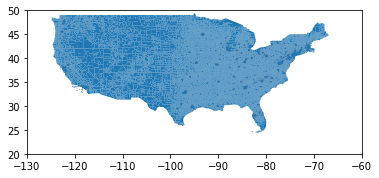

In [13]:
fig,ax = plt.subplots(1,1)
newtestgdf.plot(ax=ax)
plt.xlim(-130,-60)
plt.ylim(20,50)
plt.show()

# CALIFORNIA|

## Get water areas for whole state

In [ ]:
s = time.time()

this_state = 'CA'
this_state_number = 6
#this_state_number = state_codes_df[state_codes_df['STUSAB'] == this_state.upper()].index.values[0]

if (debug >= 1):
    print('reading area water shapefiles in {0:}...'.format(this_state))

water_gdf = geopandas.GeoDataFrame()
water_file_list = [shapefiledir+'AREAWATER/'+x for x in os.listdir(shapefiledir+'AREAWATER/') if ((x[-4:] == '.shp') and ('tl_2018_{0:02d}'.format(this_state_number) in x))]

for i in range(0, len(water_file_list)):
    if (debug >= 1):
        if ((np.mod(i,10) == 0) | (i == len(water_file_list)-1)):
            print('\tReading file {0:,.0f} of {1:,.0f}...'.format(i+1, len(water_file_list)))
    water_gdf_i = geopandas.read_file(water_file_list[i])
    #water_gdf_i = water_gdf_i[water_gdf_i['AWATER'] >= water_area_tol]
    water_gdf = pandas.concat((water_gdf, water_gdf_i), axis=0, sort=False)

water_gdf = water_gdf.set_index('HYDROID')
e = time.time()
g = g + (e-s)

if (debug >= 1):
    #print('Read {0:,.0f} bodies of water with area greater than or equal to {1:,.0f} km^2 in {2:,.0f} seconds!'.format(len(water_gdf), water_area_tol/(1000*1000), e-s))
    print('Read {0:,.0f} bodies of linear water in {1:,.0f} seconds!'.format(len(water_gdf), e-s))
#print(assembler_gdf.groupby(['STUSAB', 'block_based_district']).size())
s = time.time()

if (debug >= 1):
    print('reading place shapefiles in {0:}...'.format(this_state))

place_gdf = geopandas.GeoDataFrame()
place_file_list = [shapefiledir+'PLACE/'+x for x in os.listdir(shapefiledir+'PLACE/') if ((x[-4:] == '.shp') and ('tl_2018_{0:02d}'.format(this_state_number) in x))]

for i in range(0, len(place_file_list)):
    if (debug >= 1):
        if ((np.mod(i,10) == 0) | (i == len(water_file_list)-1)):
            print('\tReading file {0:,.0f} of {1:,.0f}...'.format(i+1, len(place_file_list)))
    place_gdf_i = geopandas.read_file(place_file_list[i])
    
    place_gdf = pandas.concat((place_gdf, place_gdf_i), axis=0, sort=False)

place_gdf.loc[:, 'INTPTLON'] = pandas.to_numeric(place_gdf['INTPTLON'], errors='coerce')
place_gdf.loc[:, 'INTPTLAT'] = pandas.to_numeric(place_gdf['INTPTLAT'], errors='coerce')

place_gdf = place_gdf.set_index('GEOID')

e = time.time()
g = g + (e-s)

if (debug >= 1):
    #print('Read {0:,.0f} bodies of water with area greater than or equal to {1:,.0f} km^2 in {2:,.0f} seconds!'.format(len(water_gdf), water_area_tol/(1000*1000), e-s))
    print('Read {0:,.0f} places in {1:,.1f} seconds!'.format(len(place_gdf), e-s))
#place_gdf.head(1)

s = time.time()

if (debug >= 1):
    print('reading roads shapefiles in {0:}...'.format(this_state))

roads_gdf = geopandas.GeoDataFrame()
roads_file_list = [shapefiledir+'ROADS/'+x for x in os.listdir(shapefiledir+'ROADS/') if ((x[-4:] == '.shp') and ('tl_2018_{0:02d}'.format(this_state_number) in x))]

for i in range(0, len(roads_file_list)):
    if (debug >= 1):
        if ((np.mod(i,10) == 0) | (i == len(water_file_list)-1)):
            print('\tReading file {0:,.0f} of {1:,.0f}...'.format(i+1, len(roads_file_list)))
    roads_gdf_i = geopandas.read_file(roads_file_list[i])
    
    roads_gdf = pandas.concat((roads_gdf, roads_gdf_i), axis=0, sort=False)

roads_gdf = roads_gdf.set_index('LINEARID')

# #roads_gdf.head(1).T
# # Road Types: C = County, I = Interstate, M = Common name, O = Other, S = State hwy, U = US hwy

old_map_buffer_ratio = -1

e = time.time()
g = g + (e-s)

if (debug >= 1):
    print('Read {0:,.0f} roads in  {1:,.0f} minutes {2:,.0f} seconds!'.format(len(roads_gdf), np.floor((e-s)/60), np.floor((e-s)%60)))

# s = time.time()
# water_gdf.to_file(shapefiledir+'texas/water_texas.shp')
# place_gdf.to_file(shapefiledir+'texas/place_texas.shp')
# roads_gdf.to_file(shapefiledir+'texas/roads_texas.shp')
# e = time.time()
print('Got California water/place/road shapefiles in {0:,.0f} minutes {1:,.0f} seconds!'.format(np.floor((e-s)/60), np.floor((e-s)%60)))

# print('Wrote outfiles in {0:,.0f} seconds!'.format(e-s))

## Define Bay Area rectangle

In [ ]:
this_state = 'CA'
nDistricts = cd_gdf[cd_gdf['STUSAB'] == this_state]['CD116FP'].max()
color_reset_point = 18

#### BAY AREA
s = time.time()
print('Defining Bay Area...')
bay_area_west_limit = unary_union(assembler_gdf[(assembler_gdf['STUSAB'] == this_state) & (assembler_gdf['COUNTY_NAME'] == 'San Mateo County')].geometry.tolist()).bounds[0] - 0.025 # West border of San mateo County
bay_area_north_limit = unary_union(assembler_gdf[(assembler_gdf['STUSAB'] == this_state) & (assembler_gdf['COUNTY_NAME'] == 'Napa County')].geometry.tolist()).bounds[1] + 0.025   # South border of Napa County
bay_area_east_limit = unary_union(assembler_gdf[(assembler_gdf['STUSAB'] == this_state) & (assembler_gdf['COUNTY_NAME'] == 'Santa Clara County')].geometry.tolist()).bounds[2] + 0.025   # East border of Santa Clara
bay_area_south_limit = unary_union(assembler_gdf[(assembler_gdf['STUSAB'] == this_state) & (assembler_gdf['COUNTY_NAME'] == 'Santa Clara County')].geometry.tolist()).bounds[1] - 0.025   # South border of Santa Clara County
xlimits = [bay_area_west_limit, bay_area_east_limit]
ylimits = [bay_area_south_limit,bay_area_north_limit]

print('\tMaking box...')
bay_area_geo = makebox(xlimits, ylimits)

print('\tMaking dataframe...')
bay_area_gdf = geopandas.GeoDataFrame(data=[[bay_area_geo]], columns=['geometry'], crs=assembler_gdf.crs, geometry='geometry')

print('\tFinding block groups in Bay Area...')
if ('in_bay_area' not in assembler_gdf.columns):
    assembler_gdf = assembler_gdf.assign(in_bay_area = False)

assembler_gdf.loc[(
    (assembler_gdf['STUSAB'] == this_state) 
    & (assembler_gdf.geometry.intersects(bay_area_geo))
), 'in_bay_area'] = True

print('\tFinding congressional districts in Bay Area...')
bay_area_districts = cd_gdf[(cd_gdf['STUSAB'] == this_state) & (cd_gdf.geometry.intersects(bay_area_geo))]['CD116FP'].drop_duplicates().sort_values().tolist()

e = time.time()
print('Found {0:,.0f} block groups in the Bay Area in {1:,.0f} minutes {2:,.0f} seconds!'.format(len(assembler_gdf[assembler_gdf['in_bay_area'] == True]), np.floor((e-s)/60), np.floor((e-s)%60)))

s = time.time()
print('Dividing water areas, places, and roads...')
water_bay_area_gdf = water_gdf[water_gdf.geometry.apply(lambda x: x.intersects(bay_area_geo))]

print('Plotting...')
legend_location = 'upper right'

fig, ax = plt.subplots(1,1,figsize=(12,8))
legend_list = []

for i in bay_area_districts:
    cd_gdf[
        (cd_gdf['STUSAB'] == this_state) & (cd_gdf['CD116FP'] == i)
    ].plot(ax=ax, color=district_color_cycle[np.mod(i, color_reset_point)-1], edgecolor='white', lw=1)

    legend_list.append(mpatches.Patch(color=district_color_cycle[np.mod(i,color_reset_point)-1], label='District {0:,.0f}'.format(i)))

print('labeling districts...')
for ix, thisrow in cd_gdf[
    (cd_gdf['STUSAB'] == this_state) 
    & (cd_gdf['CD116FP'].isin(bay_area_districts))
    & ((cd_gdf['INTPTLON'] >= xlimits[0]) & (cd_gdf['INTPTLON'] <= xlimits[1]))
    & ((cd_gdf['INTPTLAT'] >= ylimits[0]) & (cd_gdf['INTPTLAT'] <= ylimits[1]))
].iterrows():
    annotator = thisrow['CD116FP']
    showpoint = (float(thisrow['INTPTLON']), float(thisrow['INTPTLAT']))
    plt.annotate(annotator, showpoint, showpoint, 
                 fontsize=24, color='black', backgroundcolor='white', ha='center', va='center')

print('plotting block groups...')
assembler_gdf[(assembler_gdf['in_bay_area'] == True)].plot(ax=ax, color='none', edgecolor='black', lw=0.05)
#ax.legend(handles=legend_list, fontsize=12, loc=legend_location)

water_bay_area_gdf.plot(ax=ax, color='blue')

bay_area_gdf.plot(ax=ax, color='none', edgecolor='yellow', lw=1)

plt.xlim(xlimits)
plt.ylim(ylimits)

plt.show()


## Define Southern California rectangle

In [ ]:
this_state = 'CA'
nDistricts = cd_gdf[cd_gdf['STUSAB'] == this_state]['CD116FP'].max()
color_reset_point = 18

#### SOUTHERN CALIFORNIA
s = time.time()
print('Defining Southern California..')
so_cal_west_limit = unary_union(assembler_gdf[(assembler_gdf['STUSAB'] == this_state) & (assembler_gdf['COUNTY_NAME'] == 'Los Angeles County')].geometry.tolist()).bounds[0] - 0.025 # West border of Ventura County
so_cal_north_limit = unary_union(assembler_gdf[(assembler_gdf['STUSAB'] == this_state) & (assembler_gdf['COUNTY_NAME'] == 'Los Angeles County')].geometry.tolist()).bounds[3] + 0.025   # North border of Los Angeles County
so_cal_east_limit = unary_union(assembler_gdf[(assembler_gdf['STUSAB'] == this_state) & (assembler_gdf['COUNTY_NAME'] == 'Los Angeles County')].geometry.tolist()).bounds[2] + 0.025   # East border of Los Angeles County
so_cal_south_limit = unary_union(assembler_gdf[(assembler_gdf['STUSAB'] == this_state) & (assembler_gdf['COUNTY_NAME'] == 'Los Angeles County')].geometry.tolist()).bounds[1] - 0.025   # South border of Los Angeles County
#so_cal_south_limit = unary_union(assembler_gdf[(assembler_gdf['STUSAB'] == this_state)].geometry.tolist()).bounds[1] - 0.025   # South border of California
xlimits = [so_cal_west_limit, so_cal_east_limit]
ylimits = [so_cal_south_limit, so_cal_north_limit]

print('\tMaking box...')
so_cal_geo = makebox(xlimits, ylimits)

print('\tMaking dataframe...')
so_cal_gdf = geopandas.GeoDataFrame(data=[[so_cal_geo]], columns=['geometry'], crs=assembler_gdf.crs, geometry='geometry')

print('\tFinding block groups in Bay Area...')
if ('in_so_cal' not in assembler_gdf.columns):
    assembler_gdf = assembler_gdf.assign(in_so_cal = False)

assembler_gdf.loc[(
    (assembler_gdf['STUSAB'] == this_state) 
    & (assembler_gdf.geometry.intersects(so_cal_geo))
), 'in_so_cal'] = True

print('\tFinding congressional districts in Southern California...')
so_cal_districts = cd_gdf[(cd_gdf['STUSAB'] == this_state) & (cd_gdf.geometry.intersects(so_cal_geo))]['CD116FP'].drop_duplicates().sort_values().tolist()

e = time.time()
print('Found {0:,.0f} block groups in Southern California in {1:,.0f} minutes {2:,.0f} seconds!'.format(len(assembler_gdf[assembler_gdf['in_so_cal'] == True]), np.floor((e-s)/60), np.floor((e-s)%60)))

s = time.time()
print('Dividing water areas, places, and roads...')
water_so_cal_gdf = water_gdf[water_gdf.geometry.apply(lambda x: x.intersects(so_cal_geo))]
place_so_cal_gdf = place_gdf[place_gdf.geometry.apply(lambda x: x.intersects(so_cal_geo))]
roads_so_cal_gdf = roads_gdf[roads_gdf.geometry.apply(lambda x: x.intersects(so_cal_geo))]

print('Plotting...')
legend_location = 'upper right'

fig, ax = plt.subplots(1,1,figsize=(12,12))
legend_list = []

for i in so_cal_districts:
    cd_gdf[
        (cd_gdf['STUSAB'] == this_state) & (cd_gdf['CD116FP'] == i)
    ].plot(ax=ax, color=district_color_cycle[np.mod(i, color_reset_point)-1], edgecolor='white', lw=1)

    legend_list.append(mpatches.Patch(color=district_color_cycle[np.mod(i,color_reset_point)-1], label='District {0:,.0f}'.format(i)))

print('labeling districts...')
for ix, thisrow in cd_gdf[
    (cd_gdf['STUSAB'] == this_state) 
    & (cd_gdf['CD116FP'].isin(so_cal_districts))
    & ((cd_gdf['INTPTLON'] >= xlimits[0]) & (cd_gdf['INTPTLON'] <= xlimits[1]))
    & ((cd_gdf['INTPTLAT'] >= ylimits[0]) & (cd_gdf['INTPTLAT'] <= ylimits[1]))
].iterrows():
    annotator = thisrow['CD116FP']
    showpoint = (float(thisrow['INTPTLON']), float(thisrow['INTPTLAT']))
    plt.annotate(annotator, showpoint, showpoint, 
                 fontsize=14, color='black', backgroundcolor='white', ha='center', va='center')

print('plotting block groups...')
assembler_gdf[(assembler_gdf['in_so_cal'] == True)].plot(ax=ax, color='none', edgecolor='black', lw=0.05)
#ax.legend(handles=legend_list, fontsize=12, loc=legend_location)

water_so_cal_gdf.plot(ax=ax, color='blue')

so_cal_gdf.plot(ax=ax, color='none', edgecolor='pink', lw=1)

plt.xlim(xlimits)
plt.ylim(ylimits)

plt.show()


## Define regions outside Bay Area & Southern California rectangles

In [ ]:
if ('in_neither' not in assembler_gdf.columns):
    assembler_gdf = assembler_gdf.assign(in_neither = False)
assembler_gdf.loc[(assembler_gdf['STUSAB'] == this_state) & (assembler_gdf['in_bay_area'] == False) & (assembler_gdf['in_so_cal']), 'in_neither'] = True
    
    
this_state = 'CA'
nDistricts = cd_gdf[cd_gdf['STUSAB'] == 'CA']['CD116FP'].max()
color_reset_point = 18
legend_location = 'upper right'

print('splitting water...')
water_other_gdf = water_gdf[~(water_gdf.index.isin(water_bay_area_gdf.index) & ~(water_gdf.index.isin(water_so_cal_gdf.index)))]

print('splitting places...')
place_other_gdf = place_gdf[~(place_gdf.index.isin(water_bay_area_gdf.index) & ~(place_gdf.index.isin(place_so_cal_gdf.index)))]

print('splitting roads...')
roads_other_gdf = roads_gdf[~(roads_gdf.index.isin(water_bay_area_gdf.index) & ~(roads_gdf.index.isin(roads_so_cal_gdf.index)))]


fig, ax = plt.subplots(1,1,figsize=(12,8))
#legend_list = []
for i in range(1,nDistricts+1):
    cd_gdf[
        (cd_gdf['STUSAB'] == this_state) & (cd_gdf['CD116FP'] == i)
    ].plot(ax=ax, color=district_color_cycle[np.mod(i, color_reset_point)-1], edgecolor='white')

#    legend_list.append(mpatches.Patch(color=district_color_cycle[np.mod(i,color_reset_point)-1], label='District {0:,.0f}'.format(i)))

assembler_gdf[
    (assembler_gdf['STUSAB'] == this_state)
    & (assembler_gdf['in_bay_area'] == True)
].plot(ax=ax, color='none', edgecolor='pink', lw=0.1)

assembler_gdf[
    (assembler_gdf['STUSAB'] == this_state)
    & (assembler_gdf['in_so_cal'] == True)
].plot(ax=ax, color='none', edgecolor='yellow', lw=0.1)

assembler_gdf[
    (assembler_gdf['STUSAB'] == this_state)
    & (assembler_gdf['in_neither'] == True)
].plot(ax=ax, color='none', edgecolor='black', lw=0.1)

bay_area_gdf.plot(ax=ax, color='none', edgecolor='pink', lw=3)
so_cal_gdf.plot(ax=ax, color='none', edgecolor='yellow', lw=3)
#ax.legend(handles=legend_list, fontsize=12, loc=legend_location)

plt.show()


## BAY AREA

In [ ]:
# assembler_gdf.loc[['15000US060971506122'], 'block_based_district'] = 5
# assembler_gdf.loc[['15000US060952522024', '15000US060952522014'], 'block_based_district'] = 3
# assembler_gdf.loc[['15000US060952521021', '15000US060952522021'], 'block_based_district'] = 5

# assembler_gdf.loc[['15000US060133180002', '15000US060133560022', '15000US060133180003', '15000US060133601013', '15000US060133592022'], 'block_based_district'] = 5
# assembler_gdf.loc[['15000US060139900000', '15000US060133560024', '15000US060133211033', '15000US060133200041', '15000US060133211014', '15000US060133630004', '15000US060133601012', '15000US060133601012', '15000US060133601022'], 'block_based_district'] = 11
# assembler_gdf.loc[['15000US060770052061', '15000US060770052062', '15000US060770051192', '15000US060770051313', '15000US060770051351'], 'block_based_district'] = 9
# assembler_gdf.loc[['15000US060770055011', '15000US060770052021', '15000US060770051221'], 'block_based_district'] = 10
# assembler_gdf.loc[['15000US060133551083', '15000US060133040011', '15000US060133040021', '15000US060133060032', '15000US060133080011', '15000US060133551081'], 'block_based_district'] = 9
# assembler_gdf.loc[['15000US060133551071', '15000US060133551121'], 'block_based_district'] = 11
# assembler_gdf.loc[['15000US060133452031', '15000US060133452023', '15000US060133451051'], 'block_based_district'] = 11
# assembler_gdf.loc[['15000US060133551171', '15000US060133551161', '15000US060133451131', '15000US060133451142', '15000US060133451141', '15000US060133551143'], 'block_based_district'] = 15
# assembler_gdf.loc[['15000US060750179021'], 'block_based_district'] = 12
# assembler_gdf.loc[['15000US060759901000', '15000US060750255001', '15000US060750605023', '15000US060750330003', '15000US060750330004', '15000US060750303022', '15000US060750304003' , '15000US060750308005'], 'block_based_district'] = 12
# assembler_gdf.loc[['15000US060750263023', '15000US060750255002', '15000US060750306002', '15000US060750308004'], 'block_based_district'] = 14
# assembler_gdf.loc[['15000US060014338001', '15000US060014338003'], 'block_based_district'] = 13
# assembler_gdf.loc[['15000US060019900000', '15000US060014301021', '15000US060014338002', '15000US060014338004', '15000US060014304002', '15000US060014328003'], 'block_based_district'] = 15
# assembler_gdf.loc[['15000US060819901000', '15000US060816138002', '15000US060816117002', '15000US060816117004', '15000US060816096033' , '15000US060816104001', '15000US060816100001', '15000US060816102032', '15000US060816102012', '15000US060816109003'], 'block_based_district'] = 14
# assembler_gdf.loc[['15000US060816134003', '15000US060816134002', '15000US060816097001', '15000US060816099001', '15000US060816105001'], 'block_based_district'] = 18
# assembler_gdf.loc[['15000US060014507013', '15000US060014415242', '15000US060014419243', '15000US060014415031'], 'block_based_district'] = 15
# assembler_gdf.loc[['15000US060014431031', '15000US060014418001', '15000US060014418003', '15000US060014419241'], 'block_based_district'] = 17
# assembler_gdf.loc[['15000US060855077023', '15000US060855079041', '15000US060855079042', '15000US060855080043', '15000US060855059003', '15000US060855077031', '15000US060855077032', '15000US060855077034', '15000US060855077035', '15000US060855078052', '15000US060855084015'], 'block_based_district'] = 17
# assembler_gdf.loc[['15000US060855117071', '15000US060855047001', '15000US060855076001', '15000US060855100011', '15000US060855058002' , '15000US060855059002'], 'block_based_district'] = 18
# assembler_gdf.loc[['15000US060855043081', '15000US060855052031', '15000US060855057003'], 'block_based_district'] = 17
# assembler_gdf.loc[['15000US060855135001', '15000US060855042011', '15000US060855051002'], 'block_based_district'] = 19
# assembler_gdf.loc[['15000US060855119112', '15000US060855119111', '15000US060855119113', '15000US060855120271', '15000US060855120521', '15000US060855029022', '15000US060855022022' ,'15000US060855022023', '15000US060855020011', '15000US060855058001', '15000US060855020023', '15000US060855026011'], 'block_based_district'] = 18
# assembler_gdf.loc[['15000US060855121001', '15000US060855120242', '15000US060855120523', '15000US060855029032', '15000US060855029033', '15000US060855029021', '15000US060855026012', '15000US060855023022', '15000US060855005003', '15000US060855005004', '15000US060855020022'], 'block_based_district'] = 19
# assembler_gdf.loc[['15000US060871212002', '15000US060871212001'], 'block_based_district'] = 18
# assembler_gdf.loc[['15000US060879901000', '15000US060871212003', '15000US060871004001', '15000US060871005003', '15000US060871012003', '15000US060871207003'], 'block_based_district'] = 20
# assembler_gdf.loc[['15000US060855126022', '15000US060855124011', '15000US060855125092', '15000US060855125101'], 'block_based_district'] = 19
# assembler_gdf.loc[['15000US060855126021', '15000US060855125051', '15000US060855125062', '15000US060855126043', '15000US060855126032'], 'block_based_district'] = 20

# assembler_gdf[
#     (assembler_gdf['STUSAB'] == 'CA')
#     & (assembler_gdf['in_bay_area'] == True)
#     & (assembler_gdf['block_based_district'] == -1)
# ].groupby('congressional_districts_bitmask').size().sort_index(ascending=False)


In [ ]:
# s = time.time()
# #assembler_gdf = assembler_gdf_bk

# this_state = 'CA'
# test_this_bitmask = 'x00000000000000000011000000000000000000000000000000000'
# bay_area_districts = []

# for i in range(0, nDistricts+1):
#     if (test_this_bitmask[i] == '1'):
#         bay_area_districts.append(i)
#         print(i)

# manual_plot_limits = False
# show_small_roads = True
# show_places = False
# show_water = True

# # 19 vs 20
# manual_xlim = (-121.64, -121.43)
# manual_ylim = (36.90, 37.11)



# legend_location = 'upper right'

# map_buffer_ratio = .1

# fig, (ax1, ax2) = plt.subplots(1,2,figsize=(16,8))
# #fig, (ax1, ax2) = plt.subplots(2,1,figsize=(16,8))

# print('Plotting official districts...')
# for ax in (ax1, ax2):
#     legend_list = []
#     #for i in range(1, len(test_this_bitmask_philly)):
#     for i in bay_area_districts:
#         if (test_this_bitmask[i] == '1'):
#             if (i <= 18):
#                 cd_gdf[(cd_gdf['STUSAB'] == this_state) & (cd_gdf['CD116FP'] == i)].plot(ax=ax, color=district_color_cycle[i-1], label='District {0:.0f}'.format(i))
#             else:
#                 cd_gdf[(cd_gdf['STUSAB'] == this_state) & (cd_gdf['CD116FP'] == i)].plot(ax=ax, color=district_color_cycle[np.mod(i, color_reset_point)-1], label='District {0:.0f}'.format(i))
#             legend_list.append(mpatches.Patch(color=district_color_cycle[np.mod(i,color_reset_point)-1], label='District {0:,.0f}'.format(i)))


# print('plotting tracts that overlap multiple districts...')
# for ax in (ax1,ax2):
#     assembler_gdf[
#             (assembler_gdf['STUSAB'] == this_state)
#             & (assembler_gdf['in_bay_area'] == True)
#             & (assembler_gdf['block_based_district'] == -1)
#             & (assembler_gdf['congressional_districts_bitmask'] == test_this_bitmask)
#     ].plot(ax=ax, color='none', edgecolor='white', linewidth=5, zorder=100)

#     if (manual_plot_limits):
#         xlimits = (manual_xlim[0], manual_xlim[1])
#         ylimits = (manual_ylim[0], manual_ylim[1])
#     else:
#         bounding_box = unary_union(
#             assembler_gdf[
#                 (assembler_gdf['STUSAB'] == this_state)
#                 & (assembler_gdf['in_bay_area'] == True)
#                 & (assembler_gdf['block_based_district'] == -1)
#                 & (assembler_gdf['congressional_districts_bitmask'] == test_this_bitmask)
#             ].geometry.tolist()
#         ).bounds
# #        print(bounding_box)
#         xlimits = (bounding_box[0], bounding_box[2])
#         ylimits = (bounding_box[1], bounding_box[3])

#     xspan = xlimits[1] - xlimits[0]
#     yspan = ylimits[1] - ylimits[0]
#     xbuffer = xspan * map_buffer_ratio
#     ybuffer = yspan * map_buffer_ratio
#     ax.set_xlim(xlimits[0] - xbuffer, xlimits[1] + xbuffer)
#     ax.set_ylim(ylimits[0] - ybuffer, ylimits[1] + ybuffer)
  
#     ax.legend(handles=legend_list, fontsize=12, loc=legend_location)


# print('labeling block groups...')
# #####  add labels for block groups with overlap
# b = []
# for ix, thisrow in assembler_gdf[
#     (assembler_gdf['STUSAB'] == this_state) 
#         & (assembler_gdf['block_based_district'] == -1) 
#         & (assembler_gdf['in_bay_area'] == True)
#         & (assembler_gdf['congressional_districts_bitmask'] == test_this_bitmask) 
#         & ((assembler_gdf['INTPTLON'] >= xlimits[0]) & (assembler_gdf['INTPTLON'] <= xlimits[1]))
#         & ((assembler_gdf['INTPTLAT'] >= ylimits[0]) & (assembler_gdf['INTPTLAT'] <= ylimits[1]))
# ].iterrows():
#     b.append(ix)
#     annotator = ix[-6:]
#     ax1.annotate(annotator, 
#                      (float(thisrow['INTPTLON']), float(thisrow['INTPTLAT'])),
#                      (float(thisrow['INTPTLON']), float(thisrow['INTPTLAT'])),
#                  color='black', backgroundcolor='white', fontsize=10, ha='center', zorder=1000
#                )
# b = sorted(b)
# for i in range(0,len(b)):
#     print(b[i])

# if (show_water):
#     print('plotting water...')
#     water_bay_area_gdf.plot(ax=ax2, color='blue')

# print('plotting roads...')
# if (show_small_roads):
#     roads_bay_area_gdf[~roads_bay_area_gdf['RTTYP'].isin(['I','U','S','C'])].plot(ax=ax2, color='black', linewidth=0.25) 
# roads_bay_area_gdf[roads_bay_area_gdf['RTTYP'] == 'C'].plot(ax=ax2, color='black', linewidth=0.5) 
# roads_bay_area_gdf[roads_bay_area_gdf['RTTYP'] == 'S'].plot(ax=ax2, color='black', linewidth=1) 
# roads_bay_area_gdf[roads_bay_area_gdf['RTTYP'] == 'U'].plot(ax=ax2, color='black', linewidth=1.5) 
# roads_bay_area_gdf[roads_bay_area_gdf['RTTYP'] == 'I'].plot(ax=ax2, color='black', linewidth=2) 

# if (show_places):
#     print('plotting places...')
#     place_bay_area_gdf.plot(ax=ax, color='none', edgecolor='yellow', linewidth=3)
#     print('\tlabeling places in map area...')
#     for ix, thisrow in place_bay_area_gdf[
#         ((place_bay_area_gdf['INTPTLON'] >= xlimits[0] - xbuffer) & (place_bay_area_gdf['INTPTLON'] <= xlimits[1] + xbuffer))
#         & ((place_bay_area_gdf['INTPTLAT'] >= ylimits[0] - ybuffer) & (place_bay_area_gdf['INTPTLAT'] <= ylimits[1] + ybuffer))
#     ].sort_values(by='NAME').iterrows():
#         print('\t{0:}...'.format(thisrow['NAME']))
#         annotator = thisrow['NAME'].upper()
#         ax2.annotate(annotator, 
#                          (float(thisrow['INTPTLON']), float(thisrow['INTPTLAT'])),
#                          (float(thisrow['INTPTLON']), float(thisrow['INTPTLAT'])),
#                      color='red', backgroundcolor='white', fontsize=9, ha='center'
#                    )
#     print('\tlabeling places in chosen tracts...')
#     for ix, thisrow in place_bay_area_gdf[
#         ((place_bay_area_gdf['INTPTLON'] >= xlimits[0]) & (place_bay_area_gdf['INTPTLON'] <= xlimits[1]))
#         & ((place_bay_area_gdf['INTPTLAT'] >= ylimits[0]) & (place_bay_area_gdf['INTPTLAT'] <= ylimits[1]))        
#     ].iterrows():
#         annotator = thisrow['NAME'].upper()
#         plt.annotate(annotator, (thisrow.geometry.centroid.x, thisrow.geometry.centroid.y), (thisrow.geometry.centroid.x, thisrow.geometry.centroid.y), 
#                  color='red', backgroundcolor='white', fontsize=12, ha='center', va='center')

        
# plt.xticks(fontsize=14)
# plt.yticks(fontsize=14)

# plt.show()

# explore_more = b
# oldi = -1
# old_map_bufer_ratio = -1

# print('manual_xlim = ({0:,.2f}, {1:,.2f})'.format(np.floor(ax.get_xlim()[0]*100)/100, np.ceil(ax.get_xlim()[1]*100)/100))
# print('manual_ylim = ({0:,.2f}, {1:,.2f})'.format(np.floor(ax.get_ylim()[0]*100)/100, np.ceil(ax.get_ylim()[1]*100)/100))

# e = time.time()
# g = g + (e-s)
# print('Done in {0:,.0f} minutes {1:,.0f} seconds!'.format(np.floor((e-s)/60), np.floor((e-s)%60)))



In [ ]:

# s = time.time()

# #explore_more = ['15000US060855119112']

# label_small_roads = True
# label_small_road_types = []
# show_places = False
# show_water = True
# basesize = 12
# aspect_ratio = xspan / yspan
# oldi = -1

# i = 0
 
# map_buffer_ratio = .1

# suffixes_to_count_dict = {'Rd': 0, 'Dr': 0, 'St': 0,'Ave': 0, 'Blvd': 0, 'Ln': 0, 'Cir': 0, 'Way': 0, 'Ct': 0, 'Pkwy': 0, 'Pl': 0 }
# other_roads = []


# if (oldi != i):
#     print('Running this cell for the first time...')
# this_block_group_id = explore_more[i]

# print('Examining block group {0:}'.format(this_block_group_id))
# print('Population: {0:,.0f}'.format(assembler_gdf.loc[this_block_group_id]['total_population']))

# block_group_gdf = assembler_gdf[assembler_gdf.index == this_block_group_id]

# total_block_group_area = assembler_gdf[assembler_gdf.index == this_block_group_id].to_crs(equal_area_crs).geometry.apply(lambda x: x.area).values[0]
# print('Area: {0:,.1f} km^2'.format(total_block_group_area/1000000))

# xlimits = block_group_gdf.geometry.apply(lambda x: (x.bounds[0], x.bounds[2])).values[0]
# ylimits = block_group_gdf.geometry.apply(lambda x: (x.bounds[1], x.bounds[3])).values[0]

# xspan = xlimits[1] - xlimits[0]
# yspan = ylimits[1] - ylimits[0]
# aspect_ratio = xspan / yspan

# xbuffer = xspan * map_buffer_ratio
# ybuffer = yspan * map_buffer_ratio

# xlimits = block_group_gdf.geometry.apply(lambda x: (x.bounds[0] - xbuffer, x.bounds[2] + xbuffer)).values[0]
# ylimits = block_group_gdf.geometry.apply(lambda x: (x.bounds[1] - ybuffer, x.bounds[3] + ybuffer)).values[0]


# if ((oldi != i) | (old_map_buffer_ratio != map_buffer_ratio)):
#     map_area_geo = makebox(xlimits, ylimits)

# map_area_gdf = geopandas.GeoDataFrame(data=[[map_area_geo]], columns=['geometry'], crs=block_group_gdf.crs, geometry='geometry')

# print('Aspect ratio: {0:.3f}'.format(aspect_ratio))
# print('\n')

# fig, ax = plt.subplots(1,1,figsize=(basesize*aspect_ratio,basesize))

# legend_list = []
# for j in range(1, len(test_this_bitmask)):
#     if (test_this_bitmask[j] == '1'):
#         print('Matching District {0:}...'.format(j))
#         legend_list.append(mpatches.Patch(color=district_color_cycle[np.mod(j,color_reset_point)-1], label='District {0:,.0f}'.format(j)))
#         cd_gdf[(cd_gdf['STUSAB'] == this_state) & (cd_gdf['CD116FP'] == j)].plot(ax=ax, color=district_color_cycle[np.mod(j,color_reset_point)-1])
#         overlap_area = geopandas.overlay(block_group_gdf.to_crs(equal_area_crs), cd_gdf[(cd_gdf['STUSAB'] == this_state) & (cd_gdf['CD116FP'] == j)].to_crs(equal_area_crs), how='intersection').area.values[0]
#         print('\tOverlap area: {0:,.1f} km^2 ({1:.1%})'.format(overlap_area / 1000000, overlap_area / total_block_group_area))
            
            
# print('\n')



# block_group_gdf.plot(ax=ax, color='none', edgecolor='white', lw=8, zorder=100)
# map_area_gdf.plot(ax=ax, color='none', edgecolor='yellow', lw=16)

# print('finding water overlap...')
# if ((oldi != i) | (old_map_buffer_ratio != map_buffer_ratio)):
#     water_in_map_area_gdf = water_bay_area_gdf[water_bay_area_gdf.geometry.apply(lambda x: x.intersects(map_area_geo))]
#     #water_here_gdf = geopandas.overlay(water_gdf, block_group_gdf, how='intersection')
# water_in_map_area_gdf.plot(ax=ax, color='blue')

# print('finding road overlap...')
# if ((oldi != i) | (old_map_buffer_ratio != map_buffer_ratio)):
#     print('\twith block group...')
#     roads_in_block_group_gdf = roads_bay_area_gdf[roads_bay_area_gdf.geometry.apply(lambda x: x.intersects(block_group_gdf.geometry.values[0]))]
#     print('\twith full map area...')
#     roads_in_map_area_gdf = roads_bay_area_gdf[roads_bay_area_gdf.geometry.apply(lambda x: x.intersects(map_area_geo))]


# roads_in_map_area_gdf[roads_in_map_area_gdf['RTTYP'].isnull()].plot(ax=ax, color=road_label_format['O']['thecolor'], linewidth=0.5) 
# roads_in_map_area_gdf[roads_in_map_area_gdf['RTTYP'].isin(['M', 'O'])].plot(ax=ax, color=road_label_format['M']['thecolor'], linewidth=1) 
# roads_in_map_area_gdf[roads_in_map_area_gdf['RTTYP'] == 'C'].plot(ax=ax, color=road_label_format['C']['thecolor'], linewidth=2)
# roads_in_map_area_gdf[roads_in_map_area_gdf['RTTYP'] == 'S'].plot(ax=ax, color=road_label_format['S']['thecolor'], linewidth=3)
# roads_in_map_area_gdf[roads_in_map_area_gdf['RTTYP'] == 'U'].plot(ax=ax, color=road_label_format['U']['thecolor'], linewidth=4)
# roads_in_map_area_gdf[roads_in_map_area_gdf['RTTYP'] == 'I'].plot(ax=ax, color=road_label_format['I']['thecolor'], linewidth=5)


# print('labeling big roads in map area...')
# for ix, thisrow in roads_in_map_area_gdf[
#     (roads_in_map_area_gdf['FULLNAME'].notnull()) 
#     & (roads_in_map_area_gdf['RTTYP'].isin(['I', 'U', 'S']))].iterrows():
#     #& (roads_in_map_area_gdf['RTTYP'].isin(['I', 'U', 'S', 'C']))].iterrows():
#     annotator = parse_road_name(thisrow['FULLNAME'])
#     centerpoint = Point((thisrow.geometry.centroid.x, thisrow.geometry.centroid.y))
#     if (map_area_geo.contains(centerpoint)):
#         plt.annotate(annotator, (thisrow.geometry.centroid.x, thisrow.geometry.centroid.y), (thisrow.geometry.centroid.x, thisrow.geometry.centroid.y), 
#                      color='black', backgroundcolor='white', ha='center', va='center',
#                      fontsize=road_label_format[thisrow['RTTYP']]['labelsize'], bbox=road_label_format[thisrow['RTTYP']]['thebbox'])
    
# if (label_small_roads):    
#     print('labeling small roads in block group...')
#     for ix, thisrow in roads_in_block_group_gdf[(roads_in_block_group_gdf['FULLNAME'].notnull()) & (roads_in_block_group_gdf['RTTYP'].isin(['M', 'O']))].iterrows():
#         #print('\t{0:}'.format(thisrow['FULLNAME']))
#         is_other_road_type = False
#         try:
#             road_suffix = thisrow['FULLNAME'][::-1][:re.search("\s",thisrow['FULLNAME'][::-1]).start()][::-1].strip()
#             if (road_suffix in suffixes_to_count_dict):
#                 suffixes_to_count_dict[road_suffix] = suffixes_to_count_dict[road_suffix] + 1
#         except AttributeError:
#             is_other_road_type = True 
#             other_roads.append(thisrow['FULLNAME'])
        
#         if ((road_suffix in label_small_road_types) ):#| (is_other_road_type)):
#             annotator = thisrow['FULLNAME']            
#             plt.annotate(annotator, (thisrow.geometry.centroid.x, thisrow.geometry.centroid.y), (thisrow.geometry.centroid.x, thisrow.geometry.centroid.y), 
#                  color='black', backgroundcolor='white', fontsize=road_label_format[thisrow['RTTYP']]['labelsize'], ha='center', va='center'
#                         , zorder=200)


# plt.title("Block Group {0:}".format(this_block_group_id), fontsize=24)

# if (label_small_roads):
#     print("\tAnalysis of road names:")
#     for k,v in suffixes_to_count_dict.items():
#         print('\t\t{0:}: {1:,.0f}'.format(k,v))
#     print('\tOther road names:')
#     for x in other_roads:
#         print('\t\t',x)
#     print('\n')

# if (show_places):
#     print('finding places...')
#     print('\tshowing place names...')
#     for ix, thisrow in place_bay_area_gdf.iterrows():
#         if (thisrow.geometry.intersects(assembler_gdf.loc[this_block_group_id].geometry)):
#             print('\t\t',str(thisrow['NAME']))
#     print('\tplotting places...')    
#     place_dallas_gdf.plot(ax=ax, color='none', edgecolor='cyan', lw=3)
#     print('\tlabeling places...')
#     for ix, thisrow in place_bay_area_gdf[
#         ((place_bay_area_gdf['INTPTLON'] >= xlimits[0] - xbuffer) & (place_bay_area_gdf['INTPTLON'] <= xlimits[1] + xbuffer))
#         & ((place_bay_area_gdf['INTPTLAT'] >= ylimits[0] - ybuffer) & (place_bay_area_gdf['INTPTLAT'] <= ylimits[1] + ybuffer))
#     ].iterrows():
#         annotator = thisrow['NAME'].upper()
#         plt.annotate(annotator, (thisrow.geometry.centroid.x, thisrow.geometry.centroid.y), (thisrow.geometry.centroid.x, thisrow.geometry.centroid.y), 
#                  color='black', backgroundcolor='white', fontsize=11, ha='center', va='center')

# print('http://maps.google.com/maps?ll={1:.3f},{0:.3f}&spn={2:.3f},{3:.3f}&t=m'.format((xlimits[0]+xlimits[1])/2, (ylimits[0]+ylimits[1])/2, xspan, yspan))

# ax.legend(handles=legend_list, fontsize=11, loc=legend_location)
# plt.xlim(xlimits)
# plt.ylim(ylimits)

# # plt.xticks(fontsize=24)
# # plt.yticks(fontsize=24)


# plt.show()




# oldi = i
# old_map_buffer_ratio = map_buffer_ratio

# e = time.time()
# g = g + (e-s)
# print('Done in {0:,.0f} minutes {1:,.0f} seconds!'.format(np.floor((e-s)/60), np.floor((e-s)%60)))

# #map_area_geo
# if (label_small_roads):
#     print(other_roads)
# pprint(this_block_group_id)



In [ ]:
# s = time.time()
# this_state = 'CA'
# nDistricts = 53

# #assembler_gdf.loc[(assembler_gdf['STUSAB'] == this_state) & (assembler_gdf['block_based_district'] < 0), 'block_based_district'] = -5

# thedistricts = [-1,19,20]
# # # 19 vs 20
# manual_xlim = (-121.64, -121.43)
# manual_ylim = (36.90, 37.11)


# legend_location = 'lower right'

# show_real_district_boundaries = True
# district_boundary_color = 'white'

# map_buffer_ratio = .05

# fig, (ax1, ax2) = plt.subplots(1,2,figsize=(16,8))
# #fig, (ax1, ax2) = plt.subplots(2,1,figsize=(16,8))

# print('plotting block-group-based districts...')
# for ax in (ax1,ax2):
#     legend_list = []
#     for i in thedistricts:
#         print(i)
#         assembler_gdf[
#             (assembler_gdf['STUSAB'] == this_state)
#             & (assembler_gdf['block_based_district'] == i)
#         ].plot(ax=ax, color=district_color_cycle[np.mod(i, color_reset_point)-1], edgecolor='black', lw=0.25)
#         legend_list.append(mpatches.Patch(color=district_color_cycle[np.mod(i, color_reset_point)-1], label='District {0:,.0f}'.format(i)))
    
#     if (show_real_district_boundaries):
#         cd_gdf[(cd_gdf['STUSAB'] == this_state) & (cd_gdf['CD116FP'].isin(thedistricts))].plot(ax=ax, color='none', edgecolor=district_boundary_color, lw=3)

#     ax.legend(handles=legend_list, fontsize=14, loc=legend_location)

    
#     xlimits = (manual_xlim[0], manual_xlim[1])
#     ylimits = (manual_ylim[0], manual_ylim[1])
    
#     ax.set_xlim(xlimits)
#     ax.set_ylim(ylimits)



# print('labeling block groups...')
# ####  add labels for block groups with overlap
# b = []
# for ix, thisrow in assembler_gdf[
#     (assembler_gdf['STUSAB'] == this_state) 
#     & (assembler_gdf['block_based_district'] < 0)
#     #& (assembler_gdf.index == '15000US060014415031')
#     & ((assembler_gdf['INTPTLON'] >= xlimits[0]) & (assembler_gdf['INTPTLON'] <= xlimits[1]))
#     & ((assembler_gdf['INTPTLAT'] >= ylimits[0]) & (assembler_gdf['INTPTLAT'] <= ylimits[1]))
# ].iterrows():
#     b.append(ix)
#     annotator = ix[-6:]
#     ax1.annotate(annotator, 
#                      (float(thisrow['INTPTLON']), float(thisrow['INTPTLAT'])),
#                      (float(thisrow['INTPTLON']), float(thisrow['INTPTLAT'])),
#                  color='black', backgroundcolor='white', fontsize=10, ha='center', zorder=1000
#                )

# print('plotting water...')    
# water_bay_area_gdf[
#     (water_bay_area_gdf.geometry.apply(lambda x: x.centroid.x >= xlimits[0])) & ((water_bay_area_gdf.geometry.apply(lambda x: x.centroid.x) <= xlimits[1]))
#     & (water_bay_area_gdf.geometry.apply(lambda x: x.centroid.y >= ylimits[0])) & ((water_bay_area_gdf.geometry.apply(lambda x: x.centroid.y) <= ylimits[1]))
# ].plot(ax=ax2, color='blue')

# b = sorted(b)
# for i in range(0,len(b)):
#     print(b[i])

# plt.show()



## Plot Bay Area

## Southern California

In [ ]:
# # assembler_gdf.loc[['15000US060710092021'], 'block_based_district'] = 8
# # assembler_gdf.loc[['15000US060290060073'], 'block_based_district'] = 23
# # assembler_gdf.loc[['15000US060379012054', '15000US060379012053', '15000US060379007031'], 'block_based_district'] = 23
# # assembler_gdf.loc[['15000US060379003001', '15000US060379012131', '15000US060379006022', '15000US060379006062', '15000US060379102021', '15000US060379103011'], 'block_based_district'] = 25
# # assembler_gdf.loc[['15000US061110001001'], 'block_based_district'] = 24
# # assembler_gdf.loc[['15000US061119901000'], 'block_based_district'] = 26
# # assembler_gdf.loc[['15000US061110074053'], 'block_based_district'] = 26
# # assembler_gdf.loc[['15000US061110075111'], 'block_based_district'] = 30
# # assembler_gdf.loc[['15000US061110075061', '15000US061110075071', '15000US061110075142', '15000US061110079012', '15000US061110084022', '15000US061110075143'], 'block_based_district'] = 25
# # assembler_gdf.loc[['15000US061110084021', '15000US061110085003', '15000US061110075091', '15000US061110079012'], 'block_based_district'] = 26
# # assembler_gdf.loc[['15000US060379108111'], 'block_based_district'] = 27
# # assembler_gdf.loc[['15000US060379302002'], 'block_based_district'] = 28
# # assembler_gdf.loc[['15000US060379110013'], 'block_based_district'] = 25
# # assembler_gdf.loc[['15000US060379303012'], 'block_based_district'] = 27
# # assembler_gdf.loc[['15000US060379108051', '15000US060379108101'], 'block_based_district'] = 25
# # assembler_gdf.loc[['15000US061110075121', '15000US060371081021', '15000US060371081011'], 'block_based_district'] = 25
# # assembler_gdf.loc[['15000US060371132351', '15000US060371082021', '15000US060371066032', '15000US060371066431', '15000US060371082012', '15000US060371112061', '15000US060371112062'], 'block_based_district'] = 30
# # assembler_gdf.loc[['15000US060378003261', '15000US060378003263'], 'block_based_district'] = 26
# # assembler_gdf.loc[['15000US060378003242', '15000US060378003262'], 'block_based_district'] = 33
# # assembler_gdf.loc[['15000US060379301011', '15000US060374604011', '15000US060374617002', '15000US060374639002', '15000US060374639002'], 'block_based_district'] = 27
# # assembler_gdf.loc[['15000US060374608002', '15000US060374639002', '15000US060374639001', '15000US060374637002'], 'block_based_district'] = 28
# # assembler_gdf.loc[['15000US060710008081', '15000US060710008172'], 'block_based_district'] = 27
# # assembler_gdf.loc[['15000US060374005011', '15000US060374002051', '15000US060374002043', '15000US060374009002', '15000US060374039011'], 'block_based_district'] = 27
# # assembler_gdf.loc[['15000US060374016012', '15000US060374004031', '15000US060374006042', '15000US060374039013', '15000US060374008001'], 'block_based_district'] = 32
# # assembler_gdf.loc[['15000US060374315022', '15000US060374315023', '15000US060374315021', '15000US060374315022', '15000US060374321012', '15000US060374321025', '15000US060374321011', '15000US060374321022', '15000US060374329021'], 'block_based_district'] = 27
# # assembler_gdf.loc[['15000US060374310022','15000US060374313001', '15000US060374313002', '15000US060374303014', '15000US060374325001', '15000US060374325004', '15000US060374315011'], 'block_based_district'] = 32
# # assembler_gdf.loc[['15000US060374017011', '15000US060374017012'], 'block_based_district'] = 27
# # assembler_gdf.loc[['15000US060374017041'], 'block_based_district'] = 35
# # assembler_gdf.loc[['15000US060374824022', '15000US060374825221'], 'block_based_district'] = 27
# # assembler_gdf.loc[['15000US060375300031'], 'block_based_district'] = 38
# # assembler_gdf.loc[['15000US060375304002'], 'block_based_district'] = 27
# # assembler_gdf.loc[['15000US060379302001', '15000US060371041243', '15000US060379800261', '15000US060371021031', '15000US060371021042'], 'block_based_district'] = 28 
# # assembler_gdf.loc[['15000US060371041242', '15000US060371032001', '15000US060371222002', '15000US060371211021', '15000US060371211023', '15000US060371032002', '15000US060379800211'], 'block_based_district'] = 29 
# # assembler_gdf.loc[['15000US060371897013', '15000US060373108005', '15000US060373117006', '15000US060371437001'], 'block_based_district'] = 28
# # assembler_gdf.loc[['15000US060373110002', '15000US060373116004'], 'block_based_district'] = 30
# # assembler_gdf.loc[['15000US060371923001', '15000US060371944011', '15000US060371944023', '15000US060371924104', '15000US060371926201'], 'block_based_district'] = 28
# # assembler_gdf.loc[['15000US060371864041', '15000US060371924103', '15000US060371925201', '15000US060371925202', '15000US060371927002', '15000US060371958021', '15000US060371957103', '15000US060371926202'], 'block_based_district'] = 34
# # assembler_gdf.loc[['15000US060371093003', '15000US060371114001', '15000US060379800081', '15000US060371252003', '15000US060371284004', '15000US060371285002'], 'block_based_district'] = 29
# # assembler_gdf.loc[['15000US060371066031', '15000US060379800221', '15000US060371311002', '15000US060371311003', '15000US060371321022', '15000US060371236013', '15000US060371251001', '15000US060371255021', '15000US060371255022', '15000US060371256001', '15000US060371433004'], 'block_based_district'] = 30
# # assembler_gdf.loc[['15000US060371415001', '15000US060378002032'], 'block_based_district'] = 30
# # assembler_gdf.loc[['15000US060378002041'], 'block_based_district'] = 33
# # assembler_gdf.loc[['15000US060374013031', '15000US060374013042'], 'block_based_district'] = 32
# # assembler_gdf.loc[['15000US060374084023', '15000US060374083031', '15000US060374339022', '15000US060374340031', '15000US060374340032', '15000US060374331012', '15000US060374331021', '15000US060374334011', '15000US060374334012', '15000US060374334022', '15000US060374335043'], 'block_based_district'] = 32
# # assembler_gdf.loc[['15000US060375003001', '15000US060374083021', '15000US060374338012', '15000US060374335041'], 'block_based_district'] = 38
# # assembler_gdf.loc[['15000US060374082022', '15000US060374082111', '15000US060374035001'], 'block_based_district'] = 32
# # assembler_gdf.loc[['15000US060374082112', '15000US060374033031', '15000US060374082121', '15000US060374082122'], 'block_based_district'] = 39
# # assembler_gdf.loc[['15000US060372756021'], 'block_based_district'] = 43
# # assembler_gdf.loc[['15000US060372741001', '15000US060372753022', '15000US060372737003'], 'block_based_district'] = 33
# # assembler_gdf.loc[['15000US060372737001', '15000US060372738001', '15000US060372712002', '15000US060372713003', '15000US060372655101', '15000US060372656022', '15000US060372656021', '15000US060372657001', '15000US060372657003', '15000US060372676002', '15000US060372676003'], 'block_based_district'] = 37
# # assembler_gdf.loc[['15000US060376503005', '15000US060376507012', '15000US060376511021', '15000US060376514011', '15000US060376707011'], 'block_based_district'] = 33
# # assembler_gdf.loc[['15000US060372766011', '15000US060379800281'], 'block_based_district'] = 43
# # assembler_gdf.loc[['15000US060379903000'], 'block_based_district'] = 44
# # assembler_gdf.loc[['15000US060372964021', '15000US060372964023'], 'block_based_district'] = 33
# # assembler_gdf.loc[['15000US060372214021', '15000US060372242002'], 'block_based_district'] = 34
# # assembler_gdf.loc[['15000US060375309011', '15000US060375309022'], 'block_based_district'] = 34
# # assembler_gdf.loc[['15000US060375310001', '15000US060372260012', '15000US060375311013'], 'block_based_district'] = 40
# # assembler_gdf.loc[['15000US060710004013'], 'block_based_district'] = 35
# # assembler_gdf.loc[['15000US060374033213', '15000US060710001051', '15000US060374024041', '15000US060710001132', '15000US060710001152'], 'block_based_district'] = 39
# # assembler_gdf.loc[['15000US060372240201', '15000US060372240202', '15000US060372246002', '15000US060372311002'], 'block_based_district'] = 37
# # assembler_gdf.loc[['15000US060372318001'], 'block_based_district'] = 40
# # assembler_gdf.loc[['15000US060372381002', '15000US060372382002', '15000US060372382003', '15000US060372756031', '15000US060372756033', '15000US060372761003'], 'block_based_district'] = 37
# # assembler_gdf.loc[['15000US060372384001', '15000US060372384003', '15000US060372383102', '15000US060372383201'], 'block_based_district'] = 43
# # assembler_gdf.loc[['15000US060375016001', '15000US060375002025', '15000US060375002012'], 'block_based_district'] = 38
# # assembler_gdf.loc[['15000US060591103011', '15000US060374085033', '15000US060375002011'], 'block_based_district'] = 39
# # assembler_gdf.loc[['15000US060375531003', '15000US060375302021', '15000US060375302023', '15000US060375531004', '15000US060375541051', '15000US060375541052', '15000US060375542043', '15000US060375543013'], 'block_based_district'] = 38
# # assembler_gdf.loc[['15000US060375531001', '15000US060375318003', '15000US060375319021', '15000US060375542011'], 'block_based_district'] = 40
# # assembler_gdf.loc[['15000US060591101023'], 'block_based_district'] = 38
# # assembler_gdf.loc[['15000US060375715031', '15000US060591101111', '15000US060591103041'], 'block_based_district'] = 47
# # assembler_gdf.loc[['15000US060590218262', '15000US060590219152', '15000US060590219151'], 'block_based_district'] = 39
# # assembler_gdf.loc[['15000US060590219241', '15000US060590219243', '15000US060590758131', '15000US060590758133'], 'block_based_district'] = 45
# # assembler_gdf.loc[['15000US060591104023'], 'block_based_district'] = 39
# # assembler_gdf.loc[['15000US060591102011'], 'block_based_district'] = 47
# # assembler_gdf.loc[['15000US060590117222', '15000US060591104011', '15000US060590117202', '15000US060590116021', '15000US060590116022', '15000US060590868011', '15000US060590868032', '15000US060591104022'], 'block_based_district'] = 39
# # assembler_gdf.loc[['15000US060590117141', '15000US060590762022', '15000US060590864073', '15000US060590867011', '15000US060590868021', '15000US060590868013', '15000US060590117201', '15000US060590117203'], 'block_based_district'] = 46
# # assembler_gdf.loc[['15000US060591103012', '15000US060591103013'], 'block_based_district'] = 47
# # assembler_gdf.loc[['15000US060375351012'], 'block_based_district'] = 40
# # assembler_gdf.loc[['15000US060375353001', '15000US060375353003'], 'block_based_district'] = 44
# # assembler_gdf.loc[['15000US060372410013', '15000US060372911102'], 'block_based_district'] = 43
# # assembler_gdf.loc[['15000US060375435011'], 'block_based_district'] = 44
# # assembler_gdf.loc[['15000US060375706021', '15000US060375706022', '15000US060375706024', '15000US060375717033'], 'block_based_district'] = 44
# # assembler_gdf.loc[['15000US060375440021', '15000US060375723012'], 'block_based_district'] = 47
# # assembler_gdf.loc[['15000US060590755151'], 'block_based_district'] = 45
# # assembler_gdf.loc[['15000US060590755041', '15000US060590755052'], 'block_based_district'] = 45
# # assembler_gdf.loc[['15000US060590744063', '15000US060590754033', '15000US060590757012', '15000US060590757013', '15000US060590758132'], 'block_based_district'] = 46
# # assembler_gdf.loc[['15000US060590626143', '15000US060590626213', '15000US060590423331', '15000US060590626493', '15000US060590423202', '15000US060590423201'], 'block_based_district'] = 45
# # assembler_gdf.loc[['15000US060590626042', '15000US060590626102', '15000US060590626411', '15000US060590626412', '15000US060590626343', '15000US060590423352', '15000US060590423351', '15000US060590626361'], 'block_based_district'] = 48
# # assembler_gdf.loc[['15000US060590320411', '15000US060590320222', '15000US060590320431', '15000US060590320432'], 'block_based_district'] = 45
# # assembler_gdf.loc[['15000US060590320564', '15000US060590320223', '15000US060590320534', '15000US060590320563', '15000US060590320572'], 'block_based_district'] = 49
# # assembler_gdf.loc[['15000US060590878063', '15000US060590883012', '15000US060591102031', '15000US060590878011', '15000US060590878021', '15000US060590878061', '15000US060590878062'], 'block_based_district'] = 46
# # assembler_gdf.loc[['15000US060591102021', '15000US060590878031', '15000US060590878051', '15000US060590883021', '15000US060591102022', '15000US060591102023'], 'block_based_district'] = 47
# # assembler_gdf.loc[['15000US060590741061', '15000US060590741062', '15000US060590741082', '15000US060590748032'], 'block_based_district'] = 46
# # assembler_gdf.loc[['15000US060590996031', '15000US060591100073', '15000US060591100082', '15000US060590996021', '15000US060590997011', '15000US060590997012', '15000US060590997013', '15000US060591100081'], 'block_based_district'] = 47
# # assembler_gdf.loc[['15000US060590890011', '15000US060590996031', '15000US060590997022'], 'block_based_district'] = 48
# # assembler_gdf.loc[['15000US060599901000', '15000US060590423051', '15000US060590423052', '15000US060590423151', '15000US060590423152', '15000US060590423153', '15000US060590423155'], 'block_based_district'] = 48
# # assembler_gdf.loc[['15000US060590423241', '15000US060590423111', '15000US060590423113'], 'block_based_district'] = 49

# assembler_gdf[
#     (assembler_gdf['STUSAB'] == 'CA')
#     & (assembler_gdf['in_so_cal'] == True)
#     & (assembler_gdf['block_based_district'] == -1)
# ].groupby('congressional_districts_bitmask').size().sort_index(ascending=False)


In [ ]:
# s = time.time()

# this_state = 'CA'
# test_this_bitmask = 'x00000000000000000000000000000000000000000000000110000'
# so_cal_districts = []

# for i in range(0, nDistricts+1):
#     if (test_this_bitmask[i] == '1'):
#         so_cal_districts.append(i)
#         print(i)

# manual_plot_limits = False
# show_small_roads = True
# show_places = False
# show_water = True

# legend_location = 'upper right'

# map_buffer_ratio = .1

# manual_xlim = (-117.76,-117.72)
# manual_ylim = (33.47,33.52)


# fig, (ax1, ax2) = plt.subplots(1,2,figsize=(16,8))
# #fig, (ax1, ax2) = plt.subplots(2,1,figsize=(16,8))

# print('Plotting official districts...')
# for ax in (ax1, ax2):
#     legend_list = []
#     for i in so_cal_districts:
#         if (test_this_bitmask[i] == '1'):
#             legend_list.append(mpatches.Patch(color=district_color_cycle[np.mod(i,color_reset_point)-1],label='District {0:,.0f}'.format(i)))    
#             if (i <= 18):
#                 cd_gdf[(cd_gdf['STUSAB'] == this_state) & (cd_gdf['CD116FP'] == i)].plot(ax=ax, color=district_color_cycle[i-1], label='District {0:.0f}'.format(i))
#             else:
#                 cd_gdf[(cd_gdf['STUSAB'] == this_state) & (cd_gdf['CD116FP'] == i)].plot(ax=ax, color=district_color_cycle[np.mod(i, color_reset_point)-1], label='District {0:.0f}'.format(i))

#     ax.legend(handles=legend_list, fontsize=12, loc=legend_location)


# print('plotting tracts that overlap multiple districts...')
# for ax in (ax1,ax2):
#     assembler_gdf[
#             (assembler_gdf['STUSAB'] == this_state)
#             & (assembler_gdf['in_so_cal'] == True)
#             & (assembler_gdf['block_based_district'] == -1)
#             & (assembler_gdf['congressional_districts_bitmask'] == test_this_bitmask)
#     ].plot(ax=ax, color='none', edgecolor='white', linewidth=5, zorder=100)

#     if (manual_plot_limits):
#         xlimits = (manual_xlim[0], manual_xlim[1])
#         ylimits = (manual_ylim[0], manual_ylim[1])
#     else:
#         bounding_box = unary_union(
#             assembler_gdf[
#                 (assembler_gdf['STUSAB'] == this_state)
#                 & (assembler_gdf['in_so_cal'] == True)
#                 & (assembler_gdf['block_based_district'] == -1)
#                 & (assembler_gdf['congressional_districts_bitmask'] == test_this_bitmask)
#             ].geometry.tolist()
#         ).bounds
#         xlimits = (bounding_box[0], bounding_box[2])
#         ylimits = (bounding_box[1], bounding_box[3])

#     xspan = xlimits[1] - xlimits[0]
#     yspan = ylimits[1] - ylimits[0]
#     xbuffer = xspan * map_buffer_ratio
#     ybuffer = yspan * map_buffer_ratio
#     ax.set_xlim(xlimits[0] - xbuffer, xlimits[1] + xbuffer)
#     ax.set_ylim(ylimits[0] - ybuffer, ylimits[1] + ybuffer)
  
    
# print('labeling block groups...')
# #####  add labels for block groups with overlap
# b = []
# for ix, thisrow in assembler_gdf[
#     (assembler_gdf['STUSAB'] == this_state) 
#         & (assembler_gdf['block_based_district'] == -1) 
#         & (assembler_gdf['in_so_cal'] == True)
#         & (assembler_gdf['congressional_districts_bitmask'] == test_this_bitmask) 
# #         & ((assembler_gdf['INTPTLON'] >= xlimits[0]) & (assembler_gdf['INTPTLON'] <= xlimits[1]))
# #         & ((assembler_gdf['INTPTLAT'] >= ylimits[0]) & (assembler_gdf['INTPTLAT'] <= ylimits[1]))
# ].iterrows():
#     b.append(ix)
#     annotator = ix[-6:]
#     ax1.annotate(annotator, 
#                      (float(thisrow['INTPTLON']), float(thisrow['INTPTLAT'])),
#                      (float(thisrow['INTPTLON']), float(thisrow['INTPTLAT'])),
#                  color='black', backgroundcolor='white', fontsize=10, ha='center', zorder=1000
#                )
# b = sorted(b)
# for i in range(0,len(b)):
#     print(b[i])

# if (show_water):
#     print('plotting water...')
#     water_so_cal_gdf.plot(ax=ax2, color='blue')

# print('plotting roads...')
# if (show_small_roads):
#     roads_so_cal_gdf[~roads_so_cal_gdf['RTTYP'].isin(['I','U','S','C'])].plot(ax=ax2, color='black', linewidth=0.25) 
# roads_so_cal_gdf[roads_so_cal_gdf['RTTYP'] == 'C'].plot(ax=ax2, color='black', linewidth=0.5) 
# roads_so_cal_gdf[roads_so_cal_gdf['RTTYP'] == 'S'].plot(ax=ax2, color='black', linewidth=1) 
# roads_so_cal_gdf[roads_so_cal_gdf['RTTYP'] == 'U'].plot(ax=ax2, color='black', linewidth=1.5) 
# roads_so_cal_gdf[roads_so_cal_gdf['RTTYP'] == 'I'].plot(ax=ax2, color='black', linewidth=2) 

# if (show_places):
#     print('plotting places...')
#     place_so_cal_gdf.plot(ax=ax, color='none', edgecolor='yellow', linewidth=3)
#     print('\tlabeling places in map area...')
#     for ix, thisrow in place_so_cal_gdf[
#         ((place_so_cal_gdf['INTPTLON'] >= xlimits[0] - xbuffer) & (place_so_cal_gdf['INTPTLON'] <= xlimits[1] + xbuffer))
#         & ((place_so_cal_gdf['INTPTLAT'] >= ylimits[0] - ybuffer) & (place_so_cal_gdf['INTPTLAT'] <= ylimits[1] + ybuffer))
#     ].sort_values(by='NAME').iterrows():
#         print('\t{0:}...'.format(thisrow['NAME']))
#         annotator = thisrow['NAME'].upper()
#         ax2.annotate(annotator, 
#                          (float(thisrow['INTPTLON']), float(thisrow['INTPTLAT'])),
#                          (float(thisrow['INTPTLON']), float(thisrow['INTPTLAT'])),
#                      color='red', backgroundcolor='white', fontsize=9, ha='center'
#                    )
#     print('\tlabeling places in chosen tracts...')
#     for ix, thisrow in place_so_cal_gdf[
#         ((place_so_cal_gdf['INTPTLON'] >= xlimits[0]) & (place_so_cal_gdf['INTPTLON'] <= xlimits[1]))
#         & ((place_so_cal_gdf['INTPTLAT'] >= ylimits[0]) & (place_so_cal_gdf['INTPTLAT'] <= ylimits[1]))        
#     ].iterrows():
#         annotator = thisrow['NAME'].upper()
#         plt.annotate(annotator, (thisrow.geometry.centroid.x, thisrow.geometry.centroid.y), (thisrow.geometry.centroid.x, thisrow.geometry.centroid.y), 
#                  color='red', backgroundcolor='white', fontsize=12, ha='center', va='center')

        
# plt.xticks(fontsize=14)
# plt.yticks(fontsize=14)

# plt.show()

# explore_more = b
# oldi = -1
# old_map_bufer_ratio = -1

# print('manual_xlim = ({0:,.2f}, {1:,.2f})'.format(np.floor(ax.get_xlim()[0]*100)/100, np.ceil(ax.get_xlim()[1]*100)/100))
# print('manual_ylim = ({0:,.2f}, {1:,.2f})'.format(np.floor(ax.get_ylim()[0]*100)/100, np.ceil(ax.get_ylim()[1]*100)/100))

# e = time.time()
# g = g + (e-s)
# print('Done in {0:,.0f} minutes {1:,.0f} seconds!'.format(np.floor((e-s)/60), np.floor((e-s)%60)))


In [ ]:
# ## 48 vs 49
# # manual_xlim = (-117.77, -117.65)
# # manual_ylim = (33.47, 33.57)
# s = time.time()

# legend_loc = 'upper right'
# #explore_more = ['15000US060590626102']

# label_small_roads = True
# label_small_road_types = []
# show_places = False
# show_water = True
# basesize = 12
# aspect_ratio = xspan / yspan
# oldi = -1

# i = 1

# map_buffer_ratio = .1

# suffixes_to_count_dict = {'Rd': 0, 'Dr': 0, 'St': 0,'Ave': 0, 'Blvd': 0, 'Ln': 0, 'Cir': 0, 'Way': 0, 'Ct': 0, 'Pkwy': 0, 'Pl': 0 }
# other_roads = []


# if (oldi != i):
#     print('Running this cell for the first time...')
# this_block_group_id = explore_more[i]

# print('Examining block group {0:}'.format(this_block_group_id))
# print('Population: {0:,.0f}'.format(assembler_gdf.loc[this_block_group_id]['total_population']))

# block_group_gdf = assembler_gdf[assembler_gdf.index == this_block_group_id]

# total_block_group_area = assembler_gdf[assembler_gdf.index == this_block_group_id].to_crs(equal_area_crs).geometry.apply(lambda x: x.area).values[0]
# print('Area: {0:,.1f} km^2'.format(total_block_group_area/1000000))

# xlimits = block_group_gdf.geometry.apply(lambda x: (x.bounds[0], x.bounds[2])).values[0]
# ylimits = block_group_gdf.geometry.apply(lambda x: (x.bounds[1], x.bounds[3])).values[0]

# xspan = xlimits[1] - xlimits[0]
# yspan = ylimits[1] - ylimits[0]
# aspect_ratio = xspan / yspan

# xbuffer = xspan * map_buffer_ratio
# ybuffer = yspan * map_buffer_ratio

# xlimits = block_group_gdf.geometry.apply(lambda x: (x.bounds[0] - xbuffer, x.bounds[2] + xbuffer)).values[0]
# ylimits = block_group_gdf.geometry.apply(lambda x: (x.bounds[1] - ybuffer, x.bounds[3] + ybuffer)).values[0]


# if ((oldi != i) | (old_map_buffer_ratio != map_buffer_ratio)):
#     map_area_geo = makebox(xlimits, ylimits)

# map_area_gdf = geopandas.GeoDataFrame(data=[[map_area_geo]], columns=['geometry'], crs=block_group_gdf.crs, geometry='geometry')

# print('Aspect ratio: {0:.3f}'.format(aspect_ratio))
# print('\n')

# fig, ax = plt.subplots(1,1,figsize=(basesize*aspect_ratio,basesize))

# legend_list = []
# for j in range(1, len(test_this_bitmask)):
#     if (test_this_bitmask[j] == '1'):
#         print('Matching District {0:}...'.format(j))
#         legend_list.append(mpatches.Patch(color=district_color_cycle[np.mod(j,color_reset_point)-1], label='District {0:,.0f}'.format(j)))
#         cd_gdf[(cd_gdf['STUSAB'] == this_state) & (cd_gdf['CD116FP'] == j)].plot(ax=ax, color=district_color_cycle[np.mod(j,color_reset_point)-1])
#         overlap_area = geopandas.overlay(block_group_gdf.to_crs(equal_area_crs), cd_gdf[(cd_gdf['STUSAB'] == this_state) & (cd_gdf['CD116FP'] == j)].to_crs(equal_area_crs), how='intersection').area.values[0]
#         print('\tOverlap area: {0:,.1f} km^2 ({1:.1%})'.format(overlap_area / 1000000, overlap_area / total_block_group_area))
            
            
# print('\n')



# block_group_gdf.plot(ax=ax, color='none', edgecolor='white', lw=8, zorder=100)
# #map_area_gdf.plot(ax=ax, color='none', edgecolor='yellow', lw=16)

# print('finding water overlap...')
# if ((oldi != i) | (old_map_buffer_ratio != map_buffer_ratio)):
#     water_in_map_area_gdf = water_so_cal_gdf[water_so_cal_gdf.geometry.apply(lambda x: x.intersects(map_area_geo))]
#     #water_here_gdf = geopandas.overlay(water_gdf, block_group_gdf, how='intersection')
# water_in_map_area_gdf.plot(ax=ax, color='blue')

# print('finding road overlap...')
# if ((oldi != i) | (old_map_buffer_ratio != map_buffer_ratio)):
#     print('\twith block group...')
#     roads_in_block_group_gdf = roads_so_cal_gdf[roads_so_cal_gdf.geometry.apply(lambda x: x.intersects(block_group_gdf.geometry.values[0]))]
#     print('\twith full map area...')
#     roads_in_map_area_gdf = roads_so_cal_gdf[roads_so_cal_gdf.geometry.apply(lambda x: x.intersects(map_area_geo))]


# roads_in_map_area_gdf[roads_in_map_area_gdf['RTTYP'].isnull()].plot(ax=ax, color=road_label_format['O']['thecolor'], linewidth=0.5) 
# roads_in_map_area_gdf[roads_in_map_area_gdf['RTTYP'].isin(['M', 'O'])].plot(ax=ax, color=road_label_format['M']['thecolor'], linewidth=1) 
# roads_in_map_area_gdf[roads_in_map_area_gdf['RTTYP'] == 'C'].plot(ax=ax, color=road_label_format['C']['thecolor'], linewidth=2)
# roads_in_map_area_gdf[roads_in_map_area_gdf['RTTYP'] == 'S'].plot(ax=ax, color=road_label_format['S']['thecolor'], linewidth=3)
# roads_in_map_area_gdf[roads_in_map_area_gdf['RTTYP'] == 'U'].plot(ax=ax, color=road_label_format['U']['thecolor'], linewidth=4)
# roads_in_map_area_gdf[roads_in_map_area_gdf['RTTYP'] == 'I'].plot(ax=ax, color=road_label_format['I']['thecolor'], linewidth=5)


# print('labeling big roads in map area...')
# for ix, thisrow in roads_in_map_area_gdf[
#     (roads_in_map_area_gdf['FULLNAME'].notnull()) 
#     & (roads_in_map_area_gdf['RTTYP'].isin(['I', 'U', 'S']))].iterrows():
#     #& (roads_in_map_area_gdf['RTTYP'].isin(['I', 'U', 'S', 'C']))].iterrows():
#     annotator = parse_road_name(thisrow['FULLNAME'])
#     centerpoint = Point((thisrow.geometry.centroid.x, thisrow.geometry.centroid.y))
#     if (map_area_geo.contains(centerpoint)):
#         plt.annotate(annotator, (thisrow.geometry.centroid.x, thisrow.geometry.centroid.y), (thisrow.geometry.centroid.x, thisrow.geometry.centroid.y), 
#                      color='black', backgroundcolor='white', ha='center', va='center',
#                      fontsize=road_label_format[thisrow['RTTYP']]['labelsize'], bbox=road_label_format[thisrow['RTTYP']]['thebbox'])
    
# if (label_small_roads):    
#     print('labeling small roads in block group...')
#     for ix, thisrow in roads_in_block_group_gdf[(roads_in_block_group_gdf['FULLNAME'].notnull()) & (roads_in_block_group_gdf['RTTYP'].isin(['M', 'O']))].iterrows():
#         #print('\t{0:}'.format(thisrow['FULLNAME']))
#         is_other_road_type = False
#         try:
#             road_suffix = thisrow['FULLNAME'][::-1][:re.search("\s",thisrow['FULLNAME'][::-1]).start()][::-1].strip()
#             if (road_suffix in suffixes_to_count_dict):
#                 suffixes_to_count_dict[road_suffix] = suffixes_to_count_dict[road_suffix] + 1
#         except AttributeError:
#             is_other_road_type = True 
#             other_roads.append(thisrow['FULLNAME'])
        
#         if ((road_suffix in label_small_road_types) ):#| (is_other_road_type)):
#             annotator = thisrow['FULLNAME']            
#             plt.annotate(annotator, (thisrow.geometry.centroid.x, thisrow.geometry.centroid.y), (thisrow.geometry.centroid.x, thisrow.geometry.centroid.y), 
#                  color='black', backgroundcolor='white', fontsize=road_label_format[thisrow['RTTYP']]['labelsize'], ha='center', va='center'
#                         , zorder=200)


# plt.title("Block Group {0:}".format(this_block_group_id), fontsize=24)

# if (label_small_roads):
#     print("\tAnalysis of road names:")
#     for k,v in suffixes_to_count_dict.items():
#         print('\t\t{0:}: {1:,.0f}'.format(k,v))
#     print('\tOther road names:')
#     for x in other_roads:
#         print('\t\t',x)
#     print('\n')

# if (show_places):
#     print('finding places...')
#     print('\tshowing place names...')
#     for ix, thisrow in place_bay_area_gdf.iterrows():
#         if (thisrow.geometry.intersects(assembler_gdf.loc[this_block_group_id].geometry)):
#             print('\t\t',str(thisrow['NAME']))
#     print('\tplotting places...')    
#     place_dallas_gdf.plot(ax=ax, color='none', edgecolor='cyan', lw=3)
#     print('\tlabeling places...')
#     for ix, thisrow in place_bay_area_gdf[
#         ((place_bay_area_gdf['INTPTLON'] >= xlimits[0] - xbuffer) & (place_bay_area_gdf['INTPTLON'] <= xlimits[1] + xbuffer))
#         & ((place_bay_area_gdf['INTPTLAT'] >= ylimits[0] - ybuffer) & (place_bay_area_gdf['INTPTLAT'] <= ylimits[1] + ybuffer))
#     ].iterrows():
#         annotator = thisrow['NAME'].upper()
#         plt.annotate(annotator, (thisrow.geometry.centroid.x, thisrow.geometry.centroid.y), (thisrow.geometry.centroid.x, thisrow.geometry.centroid.y), 
#                  color='black', backgroundcolor='white', fontsize=11, ha='center', va='center')

# print('http://maps.google.com/maps?ll={1:.3f},{0:.3f}&spn={2:.3f},{3:.3f}&t=m'.format((xlimits[0]+xlimits[1])/2, (ylimits[0]+ylimits[1])/2, xspan, yspan))

# ax.legend(handles=legend_list, fontsize=11, loc=legend_location)
# plt.xlim(xlimits)
# plt.ylim(ylimits)

# # plt.xticks(fontsize=24)
# # plt.yticks(fontsize=24)


# plt.show()




# oldi = i
# old_map_buffer_ratio = map_buffer_ratio

# e = time.time()
# g = g + (e-s)
# print('Done in {0:,.0f} minutes {1:,.0f} seconds!'.format(np.floor((e-s)/60), np.floor((e-s)%60)))

# #map_area_geo
# if (label_small_roads):
#     print(other_roads)
# pprint(this_block_group_id)



In [ ]:
# s = time.time()
# this_state = 'CA'
# nDistricts = 53

# u = -1

# assembler_gdf.loc[(assembler_gdf['STUSAB'] == this_state) & (assembler_gdf['block_based_district'] < 0), 'block_based_district'] = u
# thedistricts = [u,48,49]

# ## 48 vs 49
# manual_xlim = (-117.77, -117.65)
# manual_ylim = (33.47, 33.57)




# legend_location = 'upper right'

# show_real_district_boundaries = True
# district_boundary_color = 'white'

# map_buffer_ratio = .05

# fig, (ax1, ax2) = plt.subplots(1,2,figsize=(16,8))
# #fig, (ax1, ax2) = plt.subplots(2,1,figsize=(16,8))

# print('plotting block-group-based districts...')
# for ax in (ax1,ax2):
#     legend_list = []
#     for i in thedistricts:
#         print(i)
#         assembler_gdf[
#             (assembler_gdf['STUSAB'] == this_state)
#             & (assembler_gdf['block_based_district'] == i)
#         ].plot(ax=ax, color=district_color_cycle[np.mod(i, color_reset_point)-1], edgecolor='black', lw=0.25)
#         legend_list.append(mpatches.Patch(color=district_color_cycle[np.mod(i, color_reset_point)-1], label='District {0:,.0f}'.format(i)))
    
#     if (show_real_district_boundaries):
#         cd_gdf[(cd_gdf['STUSAB'] == this_state) & (cd_gdf['CD116FP'].isin(thedistricts))].plot(ax=ax, color='none', edgecolor=district_boundary_color, lw=3)

#     ax.legend(handles=legend_list, fontsize=14, loc=legend_location)

    
#     xlimits = (manual_xlim[0], manual_xlim[1])
#     ylimits = (manual_ylim[0], manual_ylim[1])
    
#     ax.set_xlim(xlimits)
#     ax.set_ylim(ylimits)



# print('labeling block groups...')
# ####  add labels for block groups with overlap
# b = []
# for ix, thisrow in assembler_gdf[
#     (assembler_gdf['STUSAB'] == this_state) 
#     & (assembler_gdf['block_based_district'] < 0)
#     #& (assembler_gdf.index == '15000US060710092021')
#     & ((assembler_gdf['INTPTLON'] >= xlimits[0]) & (assembler_gdf['INTPTLON'] <= xlimits[1]))
#     & ((assembler_gdf['INTPTLAT'] >= ylimits[0]) & (assembler_gdf['INTPTLAT'] <= ylimits[1]))
# ].iterrows():
#     b.append(ix)
#     annotator = ix[-6:]
#     ax1.annotate(annotator, 
#                      (float(thisrow['INTPTLON']), float(thisrow['INTPTLAT'])),
#                      (float(thisrow['INTPTLON']), float(thisrow['INTPTLAT'])),
#                  color='black', backgroundcolor='white', fontsize=10, ha='center', zorder=1000
#                )

# print('plotting water...')    
# water_so_cal_gdf[
#     (water_so_cal_gdf.geometry.apply(lambda x: x.centroid.x >= xlimits[0])) & ((water_so_cal_gdf.geometry.apply(lambda x: x.centroid.x) <= xlimits[1]))
#     & (water_so_cal_gdf.geometry.apply(lambda x: x.centroid.y >= ylimits[0])) & ((water_so_cal_gdf.geometry.apply(lambda x: x.centroid.y) <= ylimits[1]))
# ].plot(ax=ax2, color='blue')

# b = sorted(b)
# for i in range(0,len(b)):
#     print(b[i])

# plt.show()

# assembler_gdf.loc[(assembler_gdf['STUSAB'] == this_state) & (assembler_gdf['block_based_district'] < 0), 'block_based_district'] = -1


# REST OF STATE

In [ ]:

# assembler_gdf[
#     (assembler_gdf['STUSAB'] == this_state)
#     & (assembler_gdf['in_bay_area'] == False)
#     & (assembler_gdf['in_so_cal'] == False)
#     & (assembler_gdf['block_based_district'] == -1)
# ].groupby('congressional_districts_bitmask').size().sort_index(ascending=False)


In [ ]:
# s = time.time()

# this_state = 'CA'
# test_this_bitmask = 'x00000000000000000000000000000000000000000000000000011'
# other_ca_districts = []

# for i in range(0, nDistricts+1):
#     if (test_this_bitmask[i] == '1'):
#         other_ca_districts.append(i)
#         print(i)

# manual_plot_limits = False
# show_roads = False
# show_places = False
# show_water = False

# legend_location = 'upper right'

# map_buffer_ratio = .05
# manual_xlim = (-117.04,-117)
# manual_ylim = (32.79,32.81)




# fig, (ax1, ax2) = plt.subplots(1,2,figsize=(16,8))
# #fig, (ax1, ax2) = plt.subplots(2,1,figsize=(16,8))

# print('Plotting official districts...')
# for ax in (ax1, ax2):
#     legend_list = []
#     for i in other_ca_districts:
#         if (test_this_bitmask[i] == '1'):
#             if (i <= 18):
#                 cd_gdf[(cd_gdf['STUSAB'] == this_state) & (cd_gdf['CD116FP'] == i)].plot(ax=ax, color=district_color_cycle[i-1], label='District {0:.0f}'.format(i))
#                 legend_list.append(mpatches.Patch(color=district_color_cycle[np.mod(i,color_reset_point)-1],label='District {0:,.0f}'.format(i)))    
#             else:
#                 cd_gdf[(cd_gdf['STUSAB'] == this_state) & (cd_gdf['CD116FP'] == i)].plot(ax=ax, color=district_color_cycle[np.mod(i, color_reset_point)-1], label='District {0:.0f}'.format(i))
#                 legend_list.append(mpatches.Patch(color=district_color_cycle[np.mod(i,color_reset_point)-1],label='District {0:,.0f}'.format(i)))    

#     ax.legend(handles=legend_list, fontsize=12, loc=legend_location)


# print('plotting tracts that overlap multiple districts...')
# for ax in (ax1,ax2):
#     assembler_gdf[
#             (assembler_gdf['STUSAB'] == this_state)
#             & (assembler_gdf['in_bay_area'] == False)    
#             & (assembler_gdf['in_so_cal'] == False)
#             & (assembler_gdf['block_based_district'] == -1)
#             & (assembler_gdf['congressional_districts_bitmask'] == test_this_bitmask)
#     ].plot(ax=ax, color='none', edgecolor='white', linewidth=5, zorder=100)

#     if (manual_plot_limits):
#         xlimits = (manual_xlim[0], manual_xlim[1])
#         ylimits = (manual_ylim[0], manual_ylim[1])
#     else:
#         bounding_box = unary_union(
#             assembler_gdf[
#                 (assembler_gdf['STUSAB'] == this_state)
#                 & (assembler_gdf['in_bay_area'] == False)    
#                 & (assembler_gdf['in_so_cal'] == False)
#                 & (assembler_gdf['block_based_district'] == -1)
#                 & (assembler_gdf['congressional_districts_bitmask'] == test_this_bitmask)
#             ].geometry.tolist()
#         ).bounds
#         xlimits = (bounding_box[0], bounding_box[2])
#         ylimits = (bounding_box[1], bounding_box[3])

#     xspan = xlimits[1] - xlimits[0]
#     yspan = ylimits[1] - ylimits[0]
#     xbuffer = xspan * map_buffer_ratio
#     ybuffer = yspan * map_buffer_ratio
#     ax.set_xlim(xlimits[0] - xbuffer, xlimits[1] + xbuffer)
#     ax.set_ylim(ylimits[0] - ybuffer, ylimits[1] + ybuffer)
  
    
# print('labeling block groups...')
# #####  add labels for block groups with overlap
# b = []
# for ix, thisrow in assembler_gdf[
#     (assembler_gdf['STUSAB'] == this_state) 
#         & (assembler_gdf['block_based_district'] == -1) 
#         & (assembler_gdf['congressional_districts_bitmask'] == test_this_bitmask) 
#         & ((assembler_gdf['INTPTLON'] >= xlimits[0]) & (assembler_gdf['INTPTLON'] <= xlimits[1]))
#         & ((assembler_gdf['INTPTLAT'] >= ylimits[0]) & (assembler_gdf['INTPTLAT'] <= ylimits[1]))
# ].iterrows():
#     b.append(ix)
#     annotator = ix[-6:]
#     ax1.annotate(annotator, 
#                      (float(thisrow['INTPTLON']), float(thisrow['INTPTLAT'])),
#                      (float(thisrow['INTPTLON']), float(thisrow['INTPTLAT'])),
#                  color='black', backgroundcolor='white', fontsize=10, ha='center', zorder=1000
#                )
# b = sorted(b)
# for i in range(0,len(b)):
#     print(b[i])

# if (show_water):
#     print('plotting water...')
#     water_other_gdf.plot(ax=ax2, color='blue')


# if (show_roads):
#     print('plotting roads...')
#     roads_other_gdf[~roads_other_gdf['RTTYP'].isin(['I','U','S','C'])].plot(ax=ax2, color='black', linewidth=0.25) 
#     roads_other_gdf[roads_other_gdf['RTTYP'] == 'C'].plot(ax=ax2, color='black', linewidth=0.5) 
#     roads_other_gdf[roads_other_gdf['RTTYP'] == 'S'].plot(ax=ax2, color='black', linewidth=1) 
#     roads_other_gdf[roads_other_gdf['RTTYP'] == 'U'].plot(ax=ax2, color='black', linewidth=1.5) 
#     roads_other_gdf[roads_other_gdf['RTTYP'] == 'I'].plot(ax=ax2, color='black', linewidth=2) 

# if (show_places):
#     print('plotting places...')
#     place_other_gdf.plot(ax=ax, color='none', edgecolor='yellow', linewidth=3)
#     print('\tlabeling places in map area...')
#     for ix, thisrow in place_other_gdf[
#         ((place_other_gdf['INTPTLON'] >= xlimits[0] - xbuffer) & (place_so_cal_gdf['INTPTLON'] <= xlimits[1] + xbuffer))
#         & ((place_other_gdf['INTPTLAT'] >= ylimits[0] - ybuffer) & (place_other_gdf['INTPTLAT'] <= ylimits[1] + ybuffer))
#     ].sort_values(by='NAME').iterrows():
#         print('\t{0:}...'.format(thisrow['NAME']))
#         annotator = thisrow['NAME'].upper()
#         ax2.annotate(annotator, 
#                          (float(thisrow['INTPTLON']), float(thisrow['INTPTLAT'])),
#                          (float(thisrow['INTPTLON']), float(thisrow['INTPTLAT'])),
#                      color='red', backgroundcolor='white', fontsize=9, ha='center'
#                    )
#     print('\tlabeling places in chosen tracts...')
#     for ix, thisrow in place_other_gdf[
#         ((place_other_gdf['INTPTLON'] >= xlimits[0]) & (place_other_gdf['INTPTLON'] <= xlimits[1]))
#         & ((place_other_gdf['INTPTLAT'] >= ylimits[0]) & (place_other_gdf['INTPTLAT'] <= ylimits[1]))        
#     ].iterrows():
#         annotator = thisrow['NAME'].upper()
#         plt.annotate(annotator, (thisrow.geometry.centroid.x, thisrow.geometry.centroid.y), (thisrow.geometry.centroid.x, thisrow.geometry.centroid.y), 
#                  color='red', backgroundcolor='white', fontsize=12, ha='center', va='center')

        
# plt.xticks(fontsize=14)
# plt.yticks(fontsize=14)

# plt.show()

# explore_more = b
# oldi = -1
# old_map_bufer_ratio = -1

# print('manual_xlim = ({0:,.2f}, {1:,.2f})'.format(np.floor(ax.get_xlim()[0]*100)/100, np.ceil(ax.get_xlim()[1]*100)/100))
# print('manual_ylim = ({0:,.2f}, {1:,.2f})'.format(np.floor(ax.get_ylim()[0]*100)/100, np.ceil(ax.get_ylim()[1]*100)/100))

# e = time.time()
# g = g + (e-s)
# print('Done in {0:,.0f} minutes {1:,.0f} seconds!'.format(np.floor((e-s)/60), np.floor((e-s)%60)))


In [ ]:

# # manual_xlim = (-117.23, -117.00)
# # manual_ylim = (32.71, 32.84)
# s = time.time()

# legend_loc = 'upper right'
# #explore_more = ['15000US060730134191']

# label_small_roads = True
# label_small_road_types = ['Dr','St','Ave','Blvd']
# show_places = True
# show_water = True
# basesize = 12
# aspect_ratio = xspan / yspan

# i = 0

# map_buffer_ratio = 1

# suffixes_to_count_dict = {'Rd': 0, 'Dr': 0, 'St': 0,'Ave': 0, 'Blvd': 0, 'Ln': 0, 'Cir': 0, 'Way': 0, 'Ct': 0, 'Pkwy': 0, 'Pl': 0 }
# other_roads = []


# if (oldi != i):
#     print('Running this cell for the first time...')
# this_block_group_id = explore_more[i]

# print('Examining block group {0:}'.format(this_block_group_id))
# print('Population: {0:,.0f}'.format(assembler_gdf.loc[this_block_group_id]['total_population']))

# block_group_gdf = assembler_gdf[assembler_gdf.index == this_block_group_id]

# total_block_group_area = assembler_gdf[assembler_gdf.index == this_block_group_id].to_crs(equal_area_crs).geometry.apply(lambda x: x.area).values[0]
# print('Area: {0:,.1f} km^2'.format(total_block_group_area/1000000))
# xlimits = block_group_gdf.geometry.apply(lambda x: (x.bounds[0], x.bounds[2])).values[0]
# ylimits = block_group_gdf.geometry.apply(lambda x: (x.bounds[1], x.bounds[3])).values[0]

# xspan = xlimits[1] - xlimits[0]
# yspan = ylimits[1] - ylimits[0]
# aspect_ratio = xspan / yspan

# xbuffer = xspan * map_buffer_ratio
# ybuffer = yspan * map_buffer_ratio

# xlimits = block_group_gdf.geometry.apply(lambda x: (x.bounds[0] - xbuffer, x.bounds[2] + xbuffer)).values[0]
# ylimits = block_group_gdf.geometry.apply(lambda x: (x.bounds[1] - ybuffer, x.bounds[3] + ybuffer)).values[0]


# if ((oldi != i) | (old_map_buffer_ratio != map_buffer_ratio)):
#     map_area_geo = makebox(xlimits, ylimits)

# map_area_gdf = geopandas.GeoDataFrame(data=[[map_area_geo]], columns=['geometry'], crs=block_group_gdf.crs, geometry='geometry')

# print('Aspect ratio: {0:.3f}'.format(aspect_ratio))
# print('\n')

# fig, ax = plt.subplots(1,1,figsize=(basesize*aspect_ratio,basesize))

# legend_list = []
# for j in range(1, len(test_this_bitmask)):
#     if (test_this_bitmask[j] == '1'):
#         print('Matching District {0:}...'.format(j))
#         legend_list.append(mpatches.Patch(color=district_color_cycle[np.mod(j,color_reset_point)-1], label='District {0:,.0f}'.format(j)))
#         cd_gdf[(cd_gdf['STUSAB'] == this_state) & (cd_gdf['CD116FP'] == j)].plot(ax=ax, color=district_color_cycle[np.mod(j,color_reset_point)-1])
#         overlap_area = geopandas.overlay(block_group_gdf.to_crs(equal_area_crs), cd_gdf[(cd_gdf['STUSAB'] == this_state) & (cd_gdf['CD116FP'] == j)].to_crs(equal_area_crs), how='intersection').area.values[0]
#         print('\tOverlap area: {0:,.1f} km^2 ({1:.1%})'.format(overlap_area / 1000000, overlap_area / total_block_group_area))
            
            
# print('\n')



# block_group_gdf.plot(ax=ax, color='none', edgecolor='white', lw=8, zorder=100)
# #map_area_gdf.plot(ax=ax, color='none', edgecolor='yellow', lw=16)

# print('finding water overlap...')
# if ((oldi != i) | (old_map_buffer_ratio != map_buffer_ratio)):
#     water_in_map_area_gdf = water_other_gdf[water_other_gdf.geometry.apply(lambda x: x.intersects(map_area_geo))]
#     #water_here_gdf = geopandas.overlay(water_gdf, block_group_gdf, how='intersection')

# if (show_water):
#     water_in_map_area_gdf.plot(ax=ax, color='blue')

# print('finding road overlap...')
# if ((oldi != i) | (old_map_buffer_ratio != map_buffer_ratio)):
#     print('\twith block group...')
#     roads_in_block_group_gdf = roads_other_gdf[roads_other_gdf.geometry.apply(lambda x: x.intersects(block_group_gdf.geometry.values[0]))]
#     print('\twith full map area...')
#     roads_in_map_area_gdf = roads_other_gdf[roads_other_gdf.geometry.apply(lambda x: x.intersects(map_area_geo))]


# roads_in_map_area_gdf[roads_in_map_area_gdf['RTTYP'].isnull()].plot(ax=ax, color=road_label_format['O']['thecolor'], linewidth=0.5) 
# roads_in_map_area_gdf[roads_in_map_area_gdf['RTTYP'].isin(['M', 'O'])].plot(ax=ax, color=road_label_format['M']['thecolor'], linewidth=1) 
# roads_in_map_area_gdf[roads_in_map_area_gdf['RTTYP'] == 'C'].plot(ax=ax, color=road_label_format['C']['thecolor'], linewidth=2)
# roads_in_map_area_gdf[roads_in_map_area_gdf['RTTYP'] == 'S'].plot(ax=ax, color=road_label_format['S']['thecolor'], linewidth=3)
# roads_in_map_area_gdf[roads_in_map_area_gdf['RTTYP'] == 'U'].plot(ax=ax, color=road_label_format['U']['thecolor'], linewidth=4)
# roads_in_map_area_gdf[roads_in_map_area_gdf['RTTYP'] == 'I'].plot(ax=ax, color=road_label_format['I']['thecolor'], linewidth=5)


# print('labeling big roads in map area...')
# for ix, thisrow in roads_in_map_area_gdf[
#     (roads_in_map_area_gdf['FULLNAME'].notnull()) 
#     & (roads_in_map_area_gdf['RTTYP'].isin(['I', 'U', 'S']))].iterrows():
#     #& (roads_in_map_area_gdf['RTTYP'].isin(['I', 'U', 'S', 'C']))].iterrows():
#     annotator = parse_road_name(thisrow['FULLNAME'])
#     centerpoint = Point((thisrow.geometry.centroid.x, thisrow.geometry.centroid.y))
#     if (map_area_geo.contains(centerpoint)):
#         plt.annotate(annotator, (thisrow.geometry.centroid.x, thisrow.geometry.centroid.y), (thisrow.geometry.centroid.x, thisrow.geometry.centroid.y), 
#                      color='black', backgroundcolor='white', ha='center', va='center',
#                      fontsize=road_label_format[thisrow['RTTYP']]['labelsize'], bbox=road_label_format[thisrow['RTTYP']]['thebbox'])
    
# if (label_small_roads):    
#     print('labeling small roads in block group...')
#     for ix, thisrow in roads_in_block_group_gdf[(roads_in_block_group_gdf['FULLNAME'].notnull()) & (roads_in_block_group_gdf['RTTYP'].isin(['M', 'O']))].iterrows():
#         #print('\t{0:}'.format(thisrow['FULLNAME']))
#         is_other_road_type = False
#         try:
#             road_suffix = thisrow['FULLNAME'][::-1][:re.search("\s",thisrow['FULLNAME'][::-1]).start()][::-1].strip()
#             if (road_suffix in suffixes_to_count_dict):
#                 suffixes_to_count_dict[road_suffix] = suffixes_to_count_dict[road_suffix] + 1
#         except AttributeError:
#             is_other_road_type = True 
#             other_roads.append(thisrow['FULLNAME'])
        
#         if ((road_suffix in label_small_road_types) ):#| (is_other_road_type)):
#             annotator = thisrow['FULLNAME']            
#             plt.annotate(annotator, (thisrow.geometry.centroid.x, thisrow.geometry.centroid.y), (thisrow.geometry.centroid.x, thisrow.geometry.centroid.y), 
#                  color='black', backgroundcolor='white', fontsize=road_label_format[thisrow['RTTYP']]['labelsize'], ha='center', va='center'
#                         , zorder=200)


# plt.title("Block Group {0:}".format(this_block_group_id), fontsize=24)

# if (label_small_roads):
#     print("\tAnalysis of road names:")
#     for k,v in suffixes_to_count_dict.items():
#         print('\t\t{0:}: {1:,.0f}'.format(k,v))
#     print('\tOther road names:')
#     for x in other_roads:
#         print('\t\t',x)
#     print('\n')

# if (show_places):
#     print('finding places...')
#     print('\tshowing place names...')
#     for ix, thisrow in place_other_gdf.iterrows():
#         if (thisrow.geometry.intersects(assembler_gdf.loc[this_block_group_id].geometry)):
#             print('\t\t',str(thisrow['NAME']))
#     print('\tplotting places...')    
#     place_other_gdf.plot(ax=ax, color='none', edgecolor='cyan', lw=3)
#     print('\tlabeling places...')
#     for ix, thisrow in place_other_gdf[
#         ((place_other_gdf['INTPTLON'] >= xlimits[0] - xbuffer) & (place_other_gdf['INTPTLON'] <= xlimits[1] + xbuffer))
#         & ((place_other_gdf['INTPTLAT'] >= ylimits[0] - ybuffer) & (place_other_gdf['INTPTLAT'] <= ylimits[1] + ybuffer))
#     ].iterrows():
#         annotator = thisrow['NAME'].upper()
#         plt.annotate(annotator, (thisrow.geometry.centroid.x, thisrow.geometry.centroid.y), (thisrow.geometry.centroid.x, thisrow.geometry.centroid.y), 
#                  color='black', backgroundcolor='white', fontsize=11, ha='center', va='center')

# print('http://maps.google.com/maps?ll={1:.3f},{0:.3f}&spn={2:.3f},{3:.3f}&t=m'.format((xlimits[0]+xlimits[1])/2, (ylimits[0]+ylimits[1])/2, xspan, yspan))

# ax.legend(handles=legend_list, fontsize=11, loc=legend_location)
# plt.xlim(xlimits)
# plt.ylim(ylimits)

# # plt.xticks(fontsize=24)
# # plt.yticks(fontsize=24)


# plt.show()




# oldi = i
# old_map_buffer_ratio = map_buffer_ratio

# e = time.time()
# g = g + (e-s)
# print('Done in {0:,.0f} minutes {1:,.0f} seconds!'.format(np.floor((e-s)/60), np.floor((e-s)%60)))

# #map_area_geo
# if (label_small_roads):
#     print(other_roads)
# pprint(this_block_group_id)



In [ ]:
# s = time.time()
# this_state = 'CA'
# nDistricts = 53
# show_water = True

# u = -10

# assembler_gdf.loc[(assembler_gdf['STUSAB'] == this_state) & (assembler_gdf['block_based_district'] < 0), 'block_based_district'] = u
# thedistricts = [u,50,51,52,53]

# legend_location = 'lower right'

# show_real_district_boundaries = True
# district_boundary_color = 'white'

# map_buffer_ratio = .05

# #fig, (ax1, ax2) = plt.subplots(1,2,figsize=(16,8))
# fig, (ax1, ax2) = plt.subplots(2,1,figsize=(16,8))

# print('plotting block-group-based districts...')
# for ax in (ax1,ax2):
#     legend_list = []
#     for i in thedistricts:
#         print(i)
#         assembler_gdf[
#             (assembler_gdf['STUSAB'] == this_state)
#             & (assembler_gdf['block_based_district'] == i)
#         ].plot(ax=ax, color=district_color_cycle[np.mod(i, color_reset_point)-1], lw=0.25)
        
#         assembler_gdf[
#             (assembler_gdf['STUSAB'] == this_state)
#             & (assembler_gdf['block_based_district'] == i)
#         ].plot(ax=ax, color='none', edgecolor='black', lw=0.25, zorder=99)
        
#         legend_list.append(mpatches.Patch(color=district_color_cycle[np.mod(i, color_reset_point)-1], label='District {0:,.0f}'.format(i)))
    
#     if (show_real_district_boundaries):
#         cd_gdf[(cd_gdf['STUSAB'] == this_state) & (cd_gdf['CD116FP'].isin(thedistricts))].plot(ax=ax, color='none', edgecolor=district_boundary_color, lw=3)

#     ax.legend(handles=legend_list, fontsize=14, loc=legend_location)

    
#     xlimits = (manual_xlim[0], manual_xlim[1])
#     ylimits = (manual_ylim[0], manual_ylim[1])
    
#     ax.set_xlim(xlimits)
#     ax.set_ylim(ylimits)



# print('labeling block groups...')
# ####  add labels for block groups with overlap
# b = []
# for ix, thisrow in assembler_gdf[
#     (assembler_gdf['STUSAB'] == this_state) 
#     & (assembler_gdf['block_based_district'] == u)
#     #& (assembler_gdf.index == '15000US060650426202')
#     & ((assembler_gdf['INTPTLON'] >= xlimits[0]) & (assembler_gdf['INTPTLON'] <= xlimits[1]))
#     & ((assembler_gdf['INTPTLAT'] >= ylimits[0]) & (assembler_gdf['INTPTLAT'] <= ylimits[1]))
# ].iterrows():
#     b.append(ix)
#     annotator = ix[-6:]
#     ax1.annotate(annotator, 
#                      (float(thisrow['INTPTLON']), float(thisrow['INTPTLAT'])),
#                      (float(thisrow['INTPTLON']), float(thisrow['INTPTLAT'])),
#                  color='black', backgroundcolor='white', fontsize=10, ha='center', zorder=1000
#                )

# if (show_water):
#     print('plotting water...')    
#     water_other_gdf[
#         (water_other_gdf.geometry.apply(lambda x: x.centroid.x >= xlimits[0])) & ((water_other_gdf.geometry.apply(lambda x: x.centroid.x) <= xlimits[1]))
#         & (water_other_gdf.geometry.apply(lambda x: x.centroid.y >= ylimits[0])) & ((water_other_gdf.geometry.apply(lambda x: x.centroid.y) <= ylimits[1]))
#     ].plot(ax=ax2, color='blue')

# b = sorted(b)
# for i in range(0,len(b)):
#     print(b[i])

# plt.show()

# assembler_gdf.loc[(assembler_gdf['STUSAB'] == this_state) & (assembler_gdf['block_based_district'] < 0), 'block_based_district'] = -1


In [ ]:
# # 52 vs 53
# manual_xlim = (-117.24, -116.99)
# manual_ylim = (32.71, 32.84)


# # 51 vs 53
# manual_xlim = (-117.16, -116.65)
# manual_ylim = (32.55, 32.77)

# # 51 vs 52
# manual_xlim = (-117.26, -117.09)
# manual_ylim = (32.57, 32.75)

## 50 vs 53
#manual_xlim = (-117.05, -116.87)
#manual_ylim = (32.64, 32.86)

## 50 vs 52
# manual_xlim = (-117.17, -116.67)
# manual_ylim = (32.80, 33.22)

# # 50 vs 51
# manual_xlim = (-116.93, -116.00)
# manual_ylim = (32.49, 33.39)


## 49 vs 52
# manual_xlim = (-117.29, -117.05)
# manual_ylim = (32.82, 33.10)

# # 49 vs 50
# manual_xlim = (-117.27, -117.04)
# manual_ylim = (33.00, 33.56)


# # 42 vs 50
# manual_xlim = (-117.31, -117.02)
# manual_ylim = (33.43, 33.55)

# 41 vs 42
# manual_xlim = (-117.32, -117.01)
# manual_ylim = (33.67, 33.97)


# # 36 vs 42
# manual_xlim = (-117.19, -116.63)
# manual_ylim = (33.37, 33.98)


# ### 31 vs 35
# manual_xlim = (-117.57, -117.30)
# manual_ylim = (34.00, 34.17)


# # ## 24 vs 26
# manual_xlim = (-119.53, -119.01)
# manual_ylim = (34.21, 34.55)

# # 22 vs 23
# manual_xlim = (-119.36, -118.96)
# manual_ylim = (36.02, 36.72)

# # 21 vs 23
# manual_xlim = (-119.74, -118.72)
# manual_ylim = (35.05, 35.55)

# # 21 vs 22
# manual_xlim = (-119.61, -119.44)
# manual_ylim = (36.53, 36.76)

# ## 16 vs 22
# manual_xlim = (-119.90, -119.66)
# manual_ylim = (36.68, 36.82)
# 
## 16 vs 21
# manual_xlim = (-120.11, -119.62)
# manual_ylim = (36.58, 36.87)


# # # 8 vs 31
# manual_xlim = (-117.63, -116.98)
# manual_ylim = (33.96, 34.39)

# ## 6 vs 7
# manual_xlim = (-121.47, -121.24)
# manual_ylim = (38.40, 38.76)


# # # 3 vs 6
# manual_xlim = (-121.73, -121.34)
# manual_ylim = (38.16, 38.85)

# ## 3 vs 5
# manual_xlim = (-123.17, -122.30)
# manual_ylim = (38.68, 39.67)

# ## 2 vs 5
# manual_xlim = (-122.88, -122.51)
# manual_ylim = (38.22, 38.62)

# # # 1 vs 4
# manual_xlim = (-121.55, -119.86)
# manual_ylim = (38.81, 39.60)

# # # 1 vs 3
# manual_xlim = (-122.29, -121.91)
# manual_ylim = (39.43, 39.80)


# ## 46 vs 47
# manual_xlim = (-118.03, -117.92)
# manual_ylim = (33.78, 33.84)

# ## 45 vs 49
# manual_xlim = (-117.70, -117.38)
# manual_ylim = (33.49, 33.74)


# # 45 vs 48
# manual_xlim = (-117.91, -117.64)
# manual_ylim = (33.52, 33.71)

# # 45 vs 46
# manual_xlim = (-117.86, -117.80)
# manual_ylim = (33.73, 33.85)

# # 39 vs 46
# manual_xlim = (-118.02, -117.81)
# manual_ylim = (33.82, 33.88)


# # 39 vs 45
# manual_xlim = (-117.86, -117.61)
# manual_ylim = (33.73, 33.90)

# # 38 vs 40
# manual_xlim = (-118.16, -118.10)
# manual_ylim = (33.86, 34.05)

# # 38 vs 39
# manual_xlim = (-118.05, -117.94)
# manual_ylim = (33.83, 34.02)

# # 37 vs 43
# manual_xlim = (-118.43, -118.26)
# manual_ylim = (33.95, 34.00)


# # # 37 vs 40
# manual_xlim = (-118.29, -118.25)
# manual_ylim = (34.00, 34.05)

# # 35 vs 39
# manual_xlim = (-117.86, -117.63)
# manual_ylim = (33.91, 34.09)

# # 34 vs 40
# manual_xlim = (-118.27, -118.16)
# manual_ylim = (34.01, 34.06)

# # 33 vs 43
# manual_xlim = (-118.47, -118.28)
# manual_ylim = (33.73, 34.00)

# # 33 vs 37
# manual_xlim = (-118.47, -118.41)
# manual_ylim = (33.96, 34.08)

# 32 vs 39
# manual_xlim = (-118.02, -117.80)
# manual_ylim = (33.97, 34.09)

# 32 vs 38
# manual_xlim = (-118.09, -117.98)
# manual_ylim = (33.99, 34.08)


# # 29 vs 30
# manual_xlim = (-118.55, -118.33)
# manual_ylim = (34.13, 34.36)


# # 28 vs 30
# manual_xlim = (-118.39, -118.31)
# manual_ylim = (34.11, 34.19)


# # 28 vs 29
# manual_xlim = (-118.43, -118.22)
# manual_ylim = (34.19, 34.36)


# # 27 vs 32
# manual_xlim = (-118.11, -117.63)
# manual_ylim = (34.06, 34.20)

# # 27 vs 28
# manual_xlim = (-118.33, -118.13)
# manual_ylim = (34.10, 34.33)


# # 25 vs 26
# manual_xlim = (-118.86, -118.63)
# manual_ylim = (34.18, 34.40)


# # 23 vs 25
# manual_xlim = (-118.42, -118.00)
# manual_ylim = (34.56, 34.80)


# # # 19 vs 20
# manual_xlim = (-117.71, -117.38)
# manual_ylim = (34.14, 34.41)

# # 18 vs 20
# manual_xlim = (-122.12, -121.96)
# manual_ylim = (36.93, 37.10)

# # 18 vs 19
# manual_xlim = (-121.98, -121.63)
# manual_ylim = (37.10, 37.37)

# # 17 vs 19
# manual_xlim = (-122.03, -121.13)
# manual_ylim = (36.90, 37.54)

# manual_xlim = (-122.03, -121.7)
# manual_ylim = (37.3, 37.54)


# # 17 vs 18
# manual_xlim = (-122.23, -121.91)
# manual_ylim = (37.17, 37.46)

# # 15 vs 17
# manual_xlim = (-122.18, -121.63)
# manual_ylim = (37.43, 37.69)


# # 14 vs 18
# manual_xlim = (-122.44, -122.1)
# manual_ylim = (37.26, 37.54)


# # 13 vs 15
# manual_xlim = (-122.195, -122)
# manual_ylim = (37.63, 37.83)

# # 12 vs 14
# manual_xlim = (-122.51, -122.4)
# manual_ylim = (37.7, 37.76)


# # 11 vs 15
# manual_xlim = (-122.1,-121.83)
# manual_ylim = (37.72,37.84)


# 9 vs 11
# manual_xlim = (-122,-121.5)
# manual_ylim = (37.7,38.1)


# # 9 vs 10
# manual_xlim = (-121.6,-121.1)
# manual_ylim = (37.68,37.9)

# # 5 vs 11
# manual_xlim = (-122.33,-122.04)
# manual_ylim = (37.77,38.05)
